In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

Using Theano backend.
C:\Users\faisal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
importlib.reload(gr)

<module 'graph' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\graph.py'>

In [2]:
domain = ['apnea','obesity']
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
datapath='C:/Users/faisal/PycharmProjects/linkPrediction/dataframes'
modelpath='C:/Users/faisal/PycharmProjects/linkPrediction/models'
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
time=[1990,1991,1996,1,1,20]
df, key_list = ut.load_dataset(filepath, column_split)

In [ ]:
#dynamic train graphs and test graph build and save in disk 
importlib.reload(gr)
time=[2005,2006,2015,1,1,20]
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

259
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1983.gpickle saved, nodes: 3 edges: 1
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1984.gpickle saved, nodes: 9 edges: 4
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1985.gpickle saved, nodes: 6 edges: 1
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1986.gpickle saved, nodes: 10 edges: 1
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1987.gpickle saved, nodes: 8 edges: 4
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1988.gpickle saved, nodes: 11 edges: 9
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1989.gpickle saved, nodes: 16 edges: 10
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1990.gpickle saved, nodes: 21 edges: 4
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1991.gpickle saved, nodes: 31 edges: 27
C:/Users/faisal/PycharmProjects/linkPrediction/graphs

In [4]:
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2005.gpickle loaded, nodes: 70 edges: 47
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2006.gpickle loaded, nodes: 79 edges: 56
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2007.gpickle loaded, nodes: 400 edges: 699
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
C:/Users/faisal/Pycha

In [5]:
importlib.reload(fs)
importlib.reload(cl)

freq=10
#time=[2001,2007,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1310 neg in time series: 11188 pos-neg ratio: 0.11708973900607794 total: 12498


In [249]:
ts = time[1]
te = time[2]
row = node_feature[ts].columns.values.tolist()
feature_names = row[1:len(row)]
feature = ['degree']
columns_drop = list(set(feature_names).difference(set(feature)))
pruned_data = copy.deepcopy(node_feature)
pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)

In [250]:
node_list = set(g_train_static.nodes()).intersection(g_test_static.nodes())
node_list = list(node_list)

In [251]:
ts = time[1]
te = time[2]
it_index = time[4]
time_range = te - ts
total_sample = len(node_list)
feature_length = len(pruned_data[ts].iloc[1]) - 1
X = np.zeros([total_sample, time_range, feature_length])
y = np.zeros(total_sample)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (327, 9, 1) y shape: (327,)


In [252]:
for id, edge in enumerate(node_list):
    for t in range(ts, te, it_index):
        if edge in set(pruned_data[t]['node_index']):
            sample_row = np.asarray(pruned_data[t].loc[pruned_data[t]['node_index'] == edge].values[0])
            X[id][t - ts] = sample_row[1:feature_length + 1]
            y[id] = len(g_test_static[edge])

In [261]:
# s_nodes = [12542,16381,6451,3392,6539,14408,15920,12700]
# s_index = []
# X_test = np.zeros([len(s_nodes), time_range, feature_length])
# y_test = np.zeros(len(s_nodes))
# for i,nd in enumerate(s_nodes):
#     X_test[i] = X[node_list.index(nd)]
#     y_test[i] = y[node_list.index(nd)] 
#     s_index.append(node_list.index(nd))
# X_train = np.delete(X, s_index, axis =0)
# y_train = np.delete(y, s_index, axis =0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [267]:
input_length = X.shape[1]
input_dim = X.shape[2]
output_dim = 1
batch_size = 64
epoch =  40
model = Sequential()
model.add(LSTM(10, input_shape=(input_length, input_dim),return_sequences=True))
model.add(LSTM(20))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
# model.add(Dense(20, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse',
                  optimizer='Adam',
                  metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    shuffle=True,
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose=1)

Train on 261 samples, validate on 66 samples
Epoch 1/40
261/261 [==============================] - 0s 186us/step - loss: 41.8017 - acc: 0.1264 - val_loss: 20.6440 - val_acc: 0.1212
Epoch 2/40
261/261 [==============================] - 0s 202us/step - loss: 41.2588 - acc: 0.1264 - val_loss: 20.2148 - val_acc: 0.1212
Epoch 3/40
261/261 [==============================] - 0s 173us/step - loss: 40.7303 - acc: 0.1264 - val_loss: 19.8064 - val_acc: 0.1212
Epoch 4/40
261/261 [==============================] - 0s 174us/step - loss: 40.2101 - acc: 0.1264 - val_loss: 19.4124 - val_acc: 0.1212
Epoch 5/40
261/261 [==============================] - 0s 298us/step - loss: 39.7607 - acc: 0.1264 - val_loss: 18.9928 - val_acc: 0.1212
Epoch 6/40
261/261 [==============================] - 0s 395us/step - loss: 39.2068 - acc: 0.1264 - val_loss: 18.5293 - val_acc: 0.1212
Epoch 7/40
261/261 [==============================] - 0s 312us/step - loss: 38.5937 - acc: 0.1264 - val_loss: 17.9585 - val_acc: 0.1061
Epo

In [268]:
s_nodes = [12542,16381,6451,3392,6539,14408,15920,12700]
s_index = []
X_test = np.zeros([len(s_nodes), time_range, feature_length])
y_test = np.zeros(len(s_nodes))
for i,nd in enumerate(s_nodes):
    X_test[i] = X[node_list.index(nd)]
    y_test[i] = y[node_list.index(nd)] 
    s_index.append(node_list.index(nd))
y_pred = model.predict(X_test)

In [269]:
print(y_pred, y_test)

[[7.8835864]
 [7.882037 ]
 [7.790471 ]
 [7.8580966]
 [7.802829 ]
 [7.8422804]
 [7.6899853]
 [7.7237334]] [51. 51.  4. 20. 12.  8. 18. 23.]


In [6]:
t = 1981
nodes = set(key_list['id'])
g = nx.Graph()
static_graph = gr.build_graph(g, df, key_list, nodes, 1980, 2017)

In [10]:
file_name = os.path.join(graphpath, "all_year_apnea" + ".gpickle")
gr.save_graph(static_graph, file_name)

In [3]:
file_name = os.path.join(graphpath, "all_year_apnea" + ".gpickle")
static_graph = gr.load_graph(file_name)

In [ ]:
dyn_graph = {}
nodes = set(key_list['id'])
for t in range(1981,2017):
    g = nx.Graph()
    dyn_graph[t] = gr.build_graph(g, df, key_list, nodes, t, t+1)

In [3]:
dyn_graph = {}
nodes = set(key_list['id'])
# for t in range(1981,2017):
#     file_name = os.path.join(graphpath, "single_year_apnea"+str(t) +".gpickle")
#     gr.save_graph(dyn_graph[t], file_name)
    
for t in range(1981,2017):
    file_name = os.path.join(graphpath, "single_year_apnea"+str(t) +".gpickle")
    dyn_graph[t] = gr.load_graph(file_name)

In [4]:
s_nodes = [12542,16381,6451]
first = []
second = []
third = []
for t in range(1982,2016):
    degrees = list(dyn_graph[t].degree(s_nodes))
    #print(degrees,len(degrees))
    first.append(degrees[0][1])
    if len(degrees)==1:
        second.append(0)
        third.append(0)
    elif len(degrees)==2:
        third.append(0)
        second.append(degrees[1][1])
    else:
        second.append(degrees[1][1])
        third.append(degrees[2][1])
#     first.append()
#first = third

In [5]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
series = Series(first)
#print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
#print(normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
#print(inversed)

# d_set = []
# for i in range(0,len(first)-3):
#     print(first[i:i+3],first[i+3])
#     d_set.append([first[i:i+3],first[i+3]])

Min: 0.000000, Max: 136.000000


C:\Users\faisal\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [25]:
first = normalized.flatten().tolist()
d_set = []
split_point = 1
for i in range(0,len(first)-split_point):
    print(first[i:i+split_point],first[i+split_point], 1982+i+split_point,i)
    d_set.append([first[i:i+split_point],first[i+split_point]])

[0.0661764705882353] 0.029411764705882353 1983 0
[0.029411764705882353] 0.014705882352941176 1984 1
[0.014705882352941176] 0.0 1985 2
[0.0] 0.029411764705882353 1986 3
[0.029411764705882353] 0.0 1987 4
[0.0] 0.03676470588235294 1988 5
[0.03676470588235294] 0.051470588235294115 1989 6
[0.051470588235294115] 0.058823529411764705 1990 7
[0.058823529411764705] 0.2647058823529412 1991 8
[0.2647058823529412] 0.13970588235294118 1992 9
[0.13970588235294118] 0.1323529411764706 1993 10
[0.1323529411764706] 0.20588235294117646 1994 11
[0.20588235294117646] 0.3529411764705882 1995 12
[0.3529411764705882] 0.4411764705882353 1996 13
[0.4411764705882353] 0.29411764705882354 1997 14
[0.29411764705882354] 0.3602941176470588 1998 15
[0.3602941176470588] 0.38235294117647056 1999 16
[0.38235294117647056] 0.4852941176470588 2000 17
[0.4852941176470588] 0.6470588235294118 2001 18
[0.6470588235294118] 0.6397058823529411 2002 19
[0.6397058823529411] 0.5661764705882353 2003 20
[0.5661764705882353] 0.602941176

In [26]:
total_sample = len(d_set)
time_range = len(d_set[0][0])
feature_length = 1
X = np.zeros([total_sample, time_range, feature_length])
y = np.zeros(total_sample)

In [27]:
for i,row in enumerate(d_set):
    for j,row1 in enumerate(row[0]):
        X[i][j]=np.asarray(row1)
    y[i]=row[1]

23

In [38]:
y_pred=np.zeros(len(X)-10)
for split in range(10,len(X)):
    X_train = X[0:split]
    y_train = y[0:split]
    X_test = X[split:split+1]
    y_test = y[split:split+1]
    input_length = X.shape[1]
    input_dim = X.shape[2]
    output_dim = 1
    batch_size = 16
    epoch =  500
    model = Sequential()
    model.add(LSTM(20, input_shape=(input_length, input_dim),return_sequences=True))
    model.add(LSTM(40))
    model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(Dense(20, activation='sigmoid'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse',
                      optimizer='Adam',
                      metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=1)
    y_pr = model.predict(X_test)
    y_pr=y_pr.reshape(len(y_pr))
    y_pred[split-10]=y_pr

Epoch 1/500
10/10 [==============================] - 0s 1ms/step - loss: 0.9268 - acc: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 401us/step - loss: 0.9025 - acc: 0.0000e+00
Epoch 3/500
10/10 [==============================] - 0s 501us/step - loss: 0.8785 - acc: 0.0000e+00
Epoch 4/500
10/10 [==============================] - 0s 602us/step - loss: 0.8552 - acc: 0.0000e+00
Epoch 5/500
10/10 [==============================] - 0s 401us/step - loss: 0.8316 - acc: 0.0000e+00
Epoch 6/500
10/10 [==============================] - 0s 502us/step - loss: 0.8086 - acc: 0.0000e+00
Epoch 7/500
10/10 [==============================] - 0s 602us/step - loss: 0.7862 - acc: 0.0000e+00
Epoch 8/500
10/10 [==============================] - 0s 301us/step - loss: 0.7637 - acc: 0.0000e+00
Epoch 9/500
10/10 [==============================] - 0s 401us/step - loss: 0.7417 - acc: 0.0000e+00
Epoch 10/500
10/10 [==============================] - 0s 602us/step - loss: 0.7202 - acc: 0.0000e+00
E

Epoch 84/500
10/10 [==============================] - 0s 401us/step - loss: 0.0098 - acc: 0.2000
Epoch 85/500
10/10 [==============================] - 0s 501us/step - loss: 0.0081 - acc: 0.2000
Epoch 86/500
10/10 [==============================] - 0s 301us/step - loss: 0.0076 - acc: 0.2000
Epoch 87/500
10/10 [==============================] - 0s 501us/step - loss: 0.0068 - acc: 0.2000
Epoch 88/500
10/10 [==============================] - 0s 301us/step - loss: 0.0061 - acc: 0.2000
Epoch 89/500
10/10 [==============================] - 0s 401us/step - loss: 0.0061 - acc: 0.2000
Epoch 90/500
10/10 [==============================] - 0s 401us/step - loss: 0.0071 - acc: 0.2000
Epoch 91/500
10/10 [==============================] - 0s 401us/step - loss: 0.0063 - acc: 0.2000
Epoch 92/500
10/10 [==============================] - 0s 401us/step - loss: 0.0066 - acc: 0.2000
Epoch 93/500
10/10 [==============================] - 0s 401us/step - loss: 0.0071 - acc: 0.2000
Epoch 94/500
10/10 [==========

Epoch 168/500
10/10 [==============================] - 0s 701us/step - loss: 0.0063 - acc: 0.2000
Epoch 169/500
10/10 [==============================] - 0s 501us/step - loss: 0.0051 - acc: 0.2000
Epoch 170/500
10/10 [==============================] - 0s 703us/step - loss: 0.0070 - acc: 0.2000
Epoch 171/500
10/10 [==============================] - 0s 602us/step - loss: 0.0061 - acc: 0.2000
Epoch 172/500
10/10 [==============================] - 0s 500us/step - loss: 0.0092 - acc: 0.2000
Epoch 173/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0066 - acc: 0.2000
Epoch 174/500
10/10 [==============================] - 0s 501us/step - loss: 0.0040 - acc: 0.2000
Epoch 175/500
10/10 [==============================] - 0s 802us/step - loss: 0.0076 - acc: 0.2000
Epoch 176/500
10/10 [==============================] - 0s 702us/step - loss: 0.0059 - acc: 0.2000
Epoch 177/500
10/10 [==============================] - 0s 802us/step - loss: 0.0055 - acc: 0.2000
Epoch 178/500
10/10 [=

Epoch 252/500
10/10 [==============================] - 0s 702us/step - loss: 0.0072 - acc: 0.2000
Epoch 253/500
10/10 [==============================] - 0s 802us/step - loss: 0.0062 - acc: 0.2000
Epoch 254/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0053 - acc: 0.2000
Epoch 255/500
10/10 [==============================] - 0s 702us/step - loss: 0.0075 - acc: 0.2000
Epoch 256/500
10/10 [==============================] - 0s 703us/step - loss: 0.0064 - acc: 0.2000
Epoch 257/500
10/10 [==============================] - 0s 702us/step - loss: 0.0066 - acc: 0.2000
Epoch 258/500
10/10 [==============================] - 0s 902us/step - loss: 0.0053 - acc: 0.2000
Epoch 259/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0051 - acc: 0.2000
Epoch 260/500
10/10 [==============================] - 0s 802us/step - loss: 0.0071 - acc: 0.2000
Epoch 261/500
10/10 [==============================] - 0s 401us/step - loss: 0.0049 - acc: 0.2000
Epoch 262/500
10/10 [===

Epoch 336/500
10/10 [==============================] - 0s 501us/step - loss: 0.0073 - acc: 0.2000
Epoch 337/500
10/10 [==============================] - 0s 501us/step - loss: 0.0047 - acc: 0.2000
Epoch 338/500
10/10 [==============================] - 0s 501us/step - loss: 0.0056 - acc: 0.2000
Epoch 339/500
10/10 [==============================] - 0s 501us/step - loss: 0.0080 - acc: 0.2000
Epoch 340/500
10/10 [==============================] - 0s 401us/step - loss: 0.0055 - acc: 0.2000
Epoch 341/500
10/10 [==============================] - 0s 301us/step - loss: 0.0063 - acc: 0.2000
Epoch 342/500
10/10 [==============================] - 0s 401us/step - loss: 0.0054 - acc: 0.2000
Epoch 343/500
10/10 [==============================] - 0s 501us/step - loss: 0.0053 - acc: 0.2000
Epoch 344/500
10/10 [==============================] - 0s 301us/step - loss: 0.0054 - acc: 0.2000
Epoch 345/500
10/10 [==============================] - 0s 401us/step - loss: 0.0064 - acc: 0.2000
Epoch 346/500
10/10 

Epoch 420/500
10/10 [==============================] - 0s 501us/step - loss: 0.0058 - acc: 0.2000
Epoch 421/500
10/10 [==============================] - 0s 501us/step - loss: 0.0059 - acc: 0.2000
Epoch 422/500
10/10 [==============================] - 0s 802us/step - loss: 0.0061 - acc: 0.2000
Epoch 423/500
10/10 [==============================] - 0s 703us/step - loss: 0.0061 - acc: 0.2000
Epoch 424/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0049 - acc: 0.2000
Epoch 425/500
10/10 [==============================] - 0s 602us/step - loss: 0.0058 - acc: 0.2000
Epoch 426/500
10/10 [==============================] - 0s 602us/step - loss: 0.0058 - acc: 0.2000
Epoch 427/500
10/10 [==============================] - 0s 602us/step - loss: 0.0053 - acc: 0.2000
Epoch 428/500
10/10 [==============================] - 0s 501us/step - loss: 0.0072 - acc: 0.2000
Epoch 429/500
10/10 [==============================] - 0s 602us/step - loss: 0.0057 - acc: 0.2000
Epoch 430/500
10/10 [=

Epoch 4/500
11/11 [==============================] - 0s 273us/step - loss: 0.0390 - acc: 0.1818
Epoch 5/500
11/11 [==============================] - 0s 456us/step - loss: 0.0344 - acc: 0.1818
Epoch 6/500
11/11 [==============================] - 0s 274us/step - loss: 0.0301 - acc: 0.1818
Epoch 7/500
11/11 [==============================] - 0s 365us/step - loss: 0.0262 - acc: 0.1818
Epoch 8/500
11/11 [==============================] - 0s 547us/step - loss: 0.0226 - acc: 0.1818
Epoch 9/500
11/11 [==============================] - 0s 820us/step - loss: 0.0195 - acc: 0.1818
Epoch 10/500
11/11 [==============================] - 0s 274us/step - loss: 0.0168 - acc: 0.1818
Epoch 11/500
11/11 [==============================] - 0s 456us/step - loss: 0.0144 - acc: 0.1818
Epoch 12/500
11/11 [==============================] - 0s 456us/step - loss: 0.0124 - acc: 0.1818
Epoch 13/500
11/11 [==============================] - 0s 365us/step - loss: 0.0105 - acc: 0.1818
Epoch 14/500
11/11 [================

Epoch 89/500
11/11 [==============================] - 0s 456us/step - loss: 0.0057 - acc: 0.1818
Epoch 90/500
11/11 [==============================] - 0s 456us/step - loss: 0.0056 - acc: 0.1818
Epoch 91/500
11/11 [==============================] - 0s 456us/step - loss: 0.0058 - acc: 0.1818
Epoch 92/500
11/11 [==============================] - 0s 365us/step - loss: 0.0058 - acc: 0.1818
Epoch 93/500
11/11 [==============================] - 0s 365us/step - loss: 0.0058 - acc: 0.1818
Epoch 94/500
11/11 [==============================] - 0s 456us/step - loss: 0.0057 - acc: 0.1818
Epoch 95/500
11/11 [==============================] - 0s 365us/step - loss: 0.0056 - acc: 0.1818
Epoch 96/500
11/11 [==============================] - 0s 365us/step - loss: 0.0058 - acc: 0.1818
Epoch 97/500
11/11 [==============================] - 0s 456us/step - loss: 0.0056 - acc: 0.1818
Epoch 98/500
11/11 [==============================] - 0s 729us/step - loss: 0.0057 - acc: 0.1818
Epoch 99/500
11/11 [==========

Epoch 173/500
11/11 [==============================] - 0s 456us/step - loss: 0.0049 - acc: 0.1818
Epoch 174/500
11/11 [==============================] - 0s 365us/step - loss: 0.0049 - acc: 0.1818
Epoch 175/500
11/11 [==============================] - 0s 456us/step - loss: 0.0049 - acc: 0.1818
Epoch 176/500
11/11 [==============================] - 0s 365us/step - loss: 0.0048 - acc: 0.1818
Epoch 177/500
11/11 [==============================] - 0s 729us/step - loss: 0.0047 - acc: 0.1818
Epoch 178/500
11/11 [==============================] - 0s 456us/step - loss: 0.0047 - acc: 0.1818
Epoch 179/500
11/11 [==============================] - 0s 455us/step - loss: 0.0048 - acc: 0.1818
Epoch 180/500
11/11 [==============================] - 0s 273us/step - loss: 0.0048 - acc: 0.1818
Epoch 181/500
11/11 [==============================] - 0s 456us/step - loss: 0.0047 - acc: 0.1818
Epoch 182/500
11/11 [==============================] - 0s 364us/step - loss: 0.0047 - acc: 0.1818
Epoch 183/500
11/11 

Epoch 257/500
11/11 [==============================] - 0s 273us/step - loss: 0.0045 - acc: 0.1818
Epoch 258/500
11/11 [==============================] - 0s 273us/step - loss: 0.0046 - acc: 0.1818
Epoch 259/500
11/11 [==============================] - 0s 456us/step - loss: 0.0044 - acc: 0.1818
Epoch 260/500
11/11 [==============================] - 0s 547us/step - loss: 0.0044 - acc: 0.1818
Epoch 261/500
11/11 [==============================] - 0s 456us/step - loss: 0.0044 - acc: 0.1818
Epoch 262/500
11/11 [==============================] - 0s 365us/step - loss: 0.0046 - acc: 0.1818
Epoch 263/500
11/11 [==============================] - 0s 456us/step - loss: 0.0044 - acc: 0.1818
Epoch 264/500
11/11 [==============================] - 0s 729us/step - loss: 0.0046 - acc: 0.1818
Epoch 265/500
11/11 [==============================] - 0s 273us/step - loss: 0.0045 - acc: 0.1818
Epoch 266/500
11/11 [==============================] - 0s 365us/step - loss: 0.0043 - acc: 0.1818
Epoch 267/500
11/11 

Epoch 341/500
11/11 [==============================] - 0s 547us/step - loss: 0.0044 - acc: 0.1818
Epoch 342/500
11/11 [==============================] - 0s 457us/step - loss: 0.0045 - acc: 0.1818
Epoch 343/500
11/11 [==============================] - 0s 456us/step - loss: 0.0045 - acc: 0.1818
Epoch 344/500
11/11 [==============================] - 0s 365us/step - loss: 0.0043 - acc: 0.1818
Epoch 345/500
11/11 [==============================] - 0s 638us/step - loss: 0.0045 - acc: 0.1818
Epoch 346/500
11/11 [==============================] - 0s 365us/step - loss: 0.0045 - acc: 0.1818
Epoch 347/500
11/11 [==============================] - 0s 365us/step - loss: 0.0045 - acc: 0.1818
Epoch 348/500
11/11 [==============================] - 0s 638us/step - loss: 0.0044 - acc: 0.1818
Epoch 349/500
11/11 [==============================] - 0s 364us/step - loss: 0.0043 - acc: 0.1818
Epoch 350/500
11/11 [==============================] - 0s 273us/step - loss: 0.0044 - acc: 0.1818
Epoch 351/500
11/11 

Epoch 425/500
11/11 [==============================] - 0s 365us/step - loss: 0.0043 - acc: 0.1818
Epoch 426/500
11/11 [==============================] - 0s 456us/step - loss: 0.0043 - acc: 0.1818
Epoch 427/500
11/11 [==============================] - 0s 365us/step - loss: 0.0044 - acc: 0.1818
Epoch 428/500
11/11 [==============================] - 0s 456us/step - loss: 0.0043 - acc: 0.1818
Epoch 429/500
11/11 [==============================] - 0s 456us/step - loss: 0.0043 - acc: 0.1818
Epoch 430/500
11/11 [==============================] - 0s 456us/step - loss: 0.0046 - acc: 0.1818
Epoch 431/500
11/11 [==============================] - 0s 820us/step - loss: 0.0044 - acc: 0.1818
Epoch 432/500
11/11 [==============================] - 0s 456us/step - loss: 0.0044 - acc: 0.1818
Epoch 433/500
11/11 [==============================] - 0s 364us/step - loss: 0.0045 - acc: 0.1818
Epoch 434/500
11/11 [==============================] - 0s 365us/step - loss: 0.0045 - acc: 0.1818
Epoch 435/500
11/11 

Epoch 9/500
12/12 [==============================] - 0s 501us/step - loss: 0.0537 - acc: 0.1667
Epoch 10/500
12/12 [==============================] - 0s 585us/step - loss: 0.0485 - acc: 0.1667
Epoch 11/500
12/12 [==============================] - 0s 418us/step - loss: 0.0437 - acc: 0.1667
Epoch 12/500
12/12 [==============================] - 0s 501us/step - loss: 0.0391 - acc: 0.1667
Epoch 13/500
12/12 [==============================] - 0s 418us/step - loss: 0.0349 - acc: 0.1667
Epoch 14/500
12/12 [==============================] - 0s 501us/step - loss: 0.0311 - acc: 0.1667
Epoch 15/500
12/12 [==============================] - 0s 418us/step - loss: 0.0275 - acc: 0.1667
Epoch 16/500
12/12 [==============================] - 0s 501us/step - loss: 0.0245 - acc: 0.1667
Epoch 17/500
12/12 [==============================] - 0s 501us/step - loss: 0.0216 - acc: 0.1667
Epoch 18/500
12/12 [==============================] - 0s 418us/step - loss: 0.0191 - acc: 0.1667
Epoch 19/500
12/12 [===========

Epoch 94/500
12/12 [==============================] - 0s 501us/step - loss: 0.0068 - acc: 0.1667
Epoch 95/500
12/12 [==============================] - 0s 334us/step - loss: 0.0066 - acc: 0.1667
Epoch 96/500
12/12 [==============================] - 0s 334us/step - loss: 0.0066 - acc: 0.1667
Epoch 97/500
12/12 [==============================] - 0s 501us/step - loss: 0.0067 - acc: 0.1667
Epoch 98/500
12/12 [==============================] - 0s 418us/step - loss: 0.0066 - acc: 0.1667
Epoch 99/500
12/12 [==============================] - 0s 418us/step - loss: 0.0067 - acc: 0.1667
Epoch 100/500
12/12 [==============================] - 0s 585us/step - loss: 0.0066 - acc: 0.1667
Epoch 101/500
12/12 [==============================] - 0s 418us/step - loss: 0.0067 - acc: 0.1667
Epoch 102/500
12/12 [==============================] - 0s 418us/step - loss: 0.0066 - acc: 0.1667
Epoch 103/500
12/12 [==============================] - 0s 501us/step - loss: 0.0067 - acc: 0.1667
Epoch 104/500
12/12 [=====

Epoch 178/500
12/12 [==============================] - 0s 334us/step - loss: 0.0059 - acc: 0.1667
Epoch 179/500
12/12 [==============================] - 0s 251us/step - loss: 0.0060 - acc: 0.1667
Epoch 180/500
12/12 [==============================] - 0s 251us/step - loss: 0.0060 - acc: 0.1667
Epoch 181/500
12/12 [==============================] - 0s 334us/step - loss: 0.0059 - acc: 0.1667
Epoch 182/500
12/12 [==============================] - 0s 251us/step - loss: 0.0059 - acc: 0.1667
Epoch 183/500
12/12 [==============================] - 0s 334us/step - loss: 0.0061 - acc: 0.1667
Epoch 184/500
12/12 [==============================] - 0s 334us/step - loss: 0.0058 - acc: 0.1667
Epoch 185/500
12/12 [==============================] - 0s 251us/step - loss: 0.0058 - acc: 0.1667
Epoch 186/500
12/12 [==============================] - 0s 251us/step - loss: 0.0058 - acc: 0.1667
Epoch 187/500
12/12 [==============================] - 0s 335us/step - loss: 0.0059 - acc: 0.1667
Epoch 188/500
12/12 

Epoch 262/500
12/12 [==============================] - 0s 418us/step - loss: 0.0046 - acc: 0.1667
Epoch 263/500
12/12 [==============================] - 0s 334us/step - loss: 0.0048 - acc: 0.1667
Epoch 264/500
12/12 [==============================] - 0s 251us/step - loss: 0.0049 - acc: 0.1667
Epoch 265/500
12/12 [==============================] - 0s 251us/step - loss: 0.0052 - acc: 0.1667
Epoch 266/500
12/12 [==============================] - 0s 334us/step - loss: 0.0050 - acc: 0.1667
Epoch 267/500
12/12 [==============================] - 0s 334us/step - loss: 0.0048 - acc: 0.1667
Epoch 268/500
12/12 [==============================] - 0s 334us/step - loss: 0.0046 - acc: 0.1667
Epoch 269/500
12/12 [==============================] - 0s 251us/step - loss: 0.0050 - acc: 0.1667
Epoch 270/500
12/12 [==============================] - 0s 334us/step - loss: 0.0052 - acc: 0.1667
Epoch 271/500
12/12 [==============================] - 0s 334us/step - loss: 0.0049 - acc: 0.1667
Epoch 272/500
12/12 

Epoch 346/500
12/12 [==============================] - 0s 251us/step - loss: 0.0050 - acc: 0.1667
Epoch 347/500
12/12 [==============================] - 0s 334us/step - loss: 0.0049 - acc: 0.1667
Epoch 348/500
12/12 [==============================] - 0s 251us/step - loss: 0.0050 - acc: 0.1667
Epoch 349/500
12/12 [==============================] - 0s 334us/step - loss: 0.0052 - acc: 0.1667
Epoch 350/500
12/12 [==============================] - 0s 251us/step - loss: 0.0048 - acc: 0.1667
Epoch 351/500
12/12 [==============================] - 0s 251us/step - loss: 0.0047 - acc: 0.1667
Epoch 352/500
12/12 [==============================] - 0s 334us/step - loss: 0.0047 - acc: 0.1667
Epoch 353/500
12/12 [==============================] - 0s 418us/step - loss: 0.0048 - acc: 0.1667
Epoch 354/500
12/12 [==============================] - 0s 418us/step - loss: 0.0046 - acc: 0.1667
Epoch 355/500
12/12 [==============================] - 0s 668us/step - loss: 0.0048 - acc: 0.1667
Epoch 356/500
12/12 

Epoch 430/500
12/12 [==============================] - 0s 334us/step - loss: 0.0048 - acc: 0.1667
Epoch 431/500
12/12 [==============================] - 0s 418us/step - loss: 0.0051 - acc: 0.1667
Epoch 432/500
12/12 [==============================] - 0s 501us/step - loss: 0.0046 - acc: 0.1667
Epoch 433/500
12/12 [==============================] - 0s 501us/step - loss: 0.0049 - acc: 0.1667
Epoch 434/500
12/12 [==============================] - 0s 334us/step - loss: 0.0047 - acc: 0.1667
Epoch 435/500
12/12 [==============================] - 0s 334us/step - loss: 0.0045 - acc: 0.1667
Epoch 436/500
12/12 [==============================] - 0s 418us/step - loss: 0.0049 - acc: 0.1667
Epoch 437/500
12/12 [==============================] - 0s 334us/step - loss: 0.0046 - acc: 0.1667
Epoch 438/500
12/12 [==============================] - 0s 334us/step - loss: 0.0047 - acc: 0.1667
Epoch 439/500
12/12 [==============================] - 0s 501us/step - loss: 0.0049 - acc: 0.1667
Epoch 440/500
12/12 

Epoch 14/500
13/13 [==============================] - 0s 463us/step - loss: 1.0551 - acc: 0.0000e+00
Epoch 15/500
13/13 [==============================] - 0s 386us/step - loss: 1.0273 - acc: 0.0000e+00
Epoch 16/500
13/13 [==============================] - 0s 386us/step - loss: 1.0003 - acc: 0.0000e+00
Epoch 17/500
13/13 [==============================] - 0s 463us/step - loss: 0.9748 - acc: 0.0000e+00
Epoch 18/500
13/13 [==============================] - 0s 386us/step - loss: 0.9490 - acc: 0.0000e+00
Epoch 19/500
13/13 [==============================] - 0s 617us/step - loss: 0.9231 - acc: 0.0000e+00
Epoch 20/500
13/13 [==============================] - 0s 1ms/step - loss: 0.8982 - acc: 0.0000e+00
Epoch 21/500
13/13 [==============================] - 0s 386us/step - loss: 0.8741 - acc: 0.0000e+00
Epoch 22/500
13/13 [==============================] - 0s 541us/step - loss: 0.8507 - acc: 0.0000e+00
Epoch 23/500
13/13 [==============================] - 0s 849us/step - loss: 0.8254 - acc: 0.0

Epoch 97/500
13/13 [==============================] - 0s 386us/step - loss: 0.0154 - acc: 0.1538
Epoch 98/500
13/13 [==============================] - 0s 463us/step - loss: 0.0154 - acc: 0.1538
Epoch 99/500
13/13 [==============================] - 0s 386us/step - loss: 0.0152 - acc: 0.1538
Epoch 100/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0118 - acc: 0.1538
Epoch 101/500
13/13 [==============================] - 0s 3ms/step - loss: 0.0128 - acc: 0.1538
Epoch 102/500
13/13 [==============================] - 0s 540us/step - loss: 0.0141 - acc: 0.1538
Epoch 103/500
13/13 [==============================] - 0s 386us/step - loss: 0.0188 - acc: 0.1538
Epoch 104/500
13/13 [==============================] - 0s 694us/step - loss: 0.0146 - acc: 0.1538
Epoch 105/500
13/13 [==============================] - 0s 693us/step - loss: 0.0157 - acc: 0.1538
Epoch 106/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0158 - acc: 0.1538
Epoch 107/500
13/13 [========

Epoch 181/500
13/13 [==============================] - 0s 693us/step - loss: 0.0128 - acc: 0.1538
Epoch 182/500
13/13 [==============================] - 0s 617us/step - loss: 0.0115 - acc: 0.1538
Epoch 183/500
13/13 [==============================] - 0s 463us/step - loss: 0.0159 - acc: 0.1538
Epoch 184/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0131 - acc: 0.1538
Epoch 185/500
13/13 [==============================] - 0s 463us/step - loss: 0.0145 - acc: 0.1538
Epoch 186/500
13/13 [==============================] - 0s 386us/step - loss: 0.0130 - acc: 0.1538
Epoch 187/500
13/13 [==============================] - 0s 925us/step - loss: 0.0132 - acc: 0.1538
Epoch 188/500
13/13 [==============================] - 0s 386us/step - loss: 0.0128 - acc: 0.1538
Epoch 189/500
13/13 [==============================] - 0s 616us/step - loss: 0.0138 - acc: 0.1538
Epoch 190/500
13/13 [==============================] - 0s 773us/step - loss: 0.0115 - acc: 0.1538
Epoch 191/500
13/13 [=

Epoch 265/500
13/13 [==============================] - 0s 617us/step - loss: 0.0104 - acc: 0.1538
Epoch 266/500
13/13 [==============================] - 0s 386us/step - loss: 0.0097 - acc: 0.1538
Epoch 267/500
13/13 [==============================] - 0s 463us/step - loss: 0.0133 - acc: 0.1538
Epoch 268/500
13/13 [==============================] - 0s 386us/step - loss: 0.0129 - acc: 0.1538
Epoch 269/500
13/13 [==============================] - 0s 540us/step - loss: 0.0101 - acc: 0.1538
Epoch 270/500
13/13 [==============================] - 0s 385us/step - loss: 0.0113 - acc: 0.1538
Epoch 271/500
13/13 [==============================] - 0s 617us/step - loss: 0.0114 - acc: 0.1538
Epoch 272/500
13/13 [==============================] - 0s 463us/step - loss: 0.0127 - acc: 0.1538
Epoch 273/500
13/13 [==============================] - 0s 771us/step - loss: 0.0131 - acc: 0.1538
Epoch 274/500
13/13 [==============================] - 0s 386us/step - loss: 0.0111 - acc: 0.1538
Epoch 275/500
13/13 

Epoch 349/500
13/13 [==============================] - 0s 386us/step - loss: 0.0122 - acc: 0.1538
Epoch 350/500
13/13 [==============================] - 0s 694us/step - loss: 0.0110 - acc: 0.1538
Epoch 351/500
13/13 [==============================] - 0s 694us/step - loss: 0.0083 - acc: 0.1538
Epoch 352/500
13/13 [==============================] - 0s 695us/step - loss: 0.0115 - acc: 0.1538
Epoch 353/500
13/13 [==============================] - 0s 386us/step - loss: 0.0095 - acc: 0.1538
Epoch 354/500
13/13 [==============================] - 0s 694us/step - loss: 0.0103 - acc: 0.1538
Epoch 355/500
13/13 [==============================] - 0s 386us/step - loss: 0.0100 - acc: 0.1538
Epoch 356/500
13/13 [==============================] - 0s 617us/step - loss: 0.0114 - acc: 0.1538
Epoch 357/500
13/13 [==============================] - 0s 386us/step - loss: 0.0099 - acc: 0.1538
Epoch 358/500
13/13 [==============================] - 0s 463us/step - loss: 0.0100 - acc: 0.1538
Epoch 359/500
13/13 

Epoch 433/500
13/13 [==============================] - 0s 308us/step - loss: 0.0125 - acc: 0.1538
Epoch 434/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0106 - acc: 0.1538
Epoch 435/500
13/13 [==============================] - 0s 386us/step - loss: 0.0115 - acc: 0.1538
Epoch 436/500
13/13 [==============================] - 0s 463us/step - loss: 0.0101 - acc: 0.1538
Epoch 437/500
13/13 [==============================] - 0s 386us/step - loss: 0.0101 - acc: 0.1538
Epoch 438/500
13/13 [==============================] - 0s 386us/step - loss: 0.0075 - acc: 0.1538
Epoch 439/500
13/13 [==============================] - 0s 694us/step - loss: 0.0088 - acc: 0.1538
Epoch 440/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 0.1538
Epoch 441/500
13/13 [==============================] - 0s 463us/step - loss: 0.0091 - acc: 0.1538
Epoch 442/500
13/13 [==============================] - 0s 386us/step - loss: 0.0088 - acc: 0.1538
Epoch 443/500
13/13 [===

Epoch 17/500
14/14 [==============================] - 0s 358us/step - loss: 0.0580 - acc: 0.1429
Epoch 18/500
14/14 [==============================] - 0s 358us/step - loss: 0.0532 - acc: 0.1429
Epoch 19/500
14/14 [==============================] - 0s 358us/step - loss: 0.0490 - acc: 0.1429
Epoch 20/500
14/14 [==============================] - 0s 358us/step - loss: 0.0449 - acc: 0.1429
Epoch 21/500
14/14 [==============================] - 0s 501us/step - loss: 0.0415 - acc: 0.1429
Epoch 22/500
14/14 [==============================] - 0s 286us/step - loss: 0.0380 - acc: 0.1429
Epoch 23/500
14/14 [==============================] - 0s 859us/step - loss: 0.0353 - acc: 0.1429
Epoch 24/500
14/14 [==============================] - 0s 358us/step - loss: 0.0326 - acc: 0.1429
Epoch 25/500
14/14 [==============================] - 0s 286us/step - loss: 0.0304 - acc: 0.1429
Epoch 26/500
14/14 [==============================] - 0s 287us/step - loss: 0.0280 - acc: 0.1429
Epoch 27/500
14/14 [==========

Epoch 102/500
14/14 [==============================] - 0s 286us/step - loss: 0.0173 - acc: 0.1429
Epoch 103/500
14/14 [==============================] - 0s 430us/step - loss: 0.0171 - acc: 0.1429
Epoch 104/500
14/14 [==============================] - 0s 287us/step - loss: 0.0174 - acc: 0.1429
Epoch 105/500
14/14 [==============================] - 0s 358us/step - loss: 0.0173 - acc: 0.1429
Epoch 106/500
14/14 [==============================] - 0s 358us/step - loss: 0.0171 - acc: 0.1429
Epoch 107/500
14/14 [==============================] - 0s 358us/step - loss: 0.0172 - acc: 0.1429
Epoch 108/500
14/14 [==============================] - 0s 358us/step - loss: 0.0172 - acc: 0.1429
Epoch 109/500
14/14 [==============================] - 0s 287us/step - loss: 0.0169 - acc: 0.1429
Epoch 110/500
14/14 [==============================] - 0s 286us/step - loss: 0.0172 - acc: 0.1429
Epoch 111/500
14/14 [==============================] - 0s 358us/step - loss: 0.0170 - acc: 0.1429
Epoch 112/500
14/14 

Epoch 186/500
14/14 [==============================] - 0s 430us/step - loss: 0.0087 - acc: 0.1429
Epoch 187/500
14/14 [==============================] - 0s 286us/step - loss: 0.0095 - acc: 0.1429
Epoch 188/500
14/14 [==============================] - 0s 215us/step - loss: 0.0088 - acc: 0.1429
Epoch 189/500
14/14 [==============================] - 0s 286us/step - loss: 0.0086 - acc: 0.1429
Epoch 190/500
14/14 [==============================] - 0s 358us/step - loss: 0.0084 - acc: 0.1429
Epoch 191/500
14/14 [==============================] - 0s 286us/step - loss: 0.0085 - acc: 0.1429
Epoch 192/500
14/14 [==============================] - 0s 358us/step - loss: 0.0085 - acc: 0.1429
Epoch 193/500
14/14 [==============================] - 0s 286us/step - loss: 0.0082 - acc: 0.1429
Epoch 194/500
14/14 [==============================] - 0s 287us/step - loss: 0.0077 - acc: 0.1429
Epoch 195/500
14/14 [==============================] - 0s 358us/step - loss: 0.0076 - acc: 0.1429
Epoch 196/500
14/14 

Epoch 270/500
14/14 [==============================] - 0s 358us/step - loss: 0.0066 - acc: 0.1429
Epoch 271/500
14/14 [==============================] - 0s 358us/step - loss: 0.0059 - acc: 0.1429
Epoch 272/500
14/14 [==============================] - 0s 358us/step - loss: 0.0064 - acc: 0.1429
Epoch 273/500
14/14 [==============================] - 0s 358us/step - loss: 0.0066 - acc: 0.1429
Epoch 274/500
14/14 [==============================] - 0s 358us/step - loss: 0.0061 - acc: 0.1429
Epoch 275/500
14/14 [==============================] - 0s 430us/step - loss: 0.0069 - acc: 0.1429
Epoch 276/500
14/14 [==============================] - 0s 286us/step - loss: 0.0063 - acc: 0.1429
Epoch 277/500
14/14 [==============================] - 0s 287us/step - loss: 0.0062 - acc: 0.1429
Epoch 278/500
14/14 [==============================] - 0s 287us/step - loss: 0.0057 - acc: 0.1429
Epoch 279/500
14/14 [==============================] - 0s 430us/step - loss: 0.0063 - acc: 0.1429
Epoch 280/500
14/14 

Epoch 354/500
14/14 [==============================] - 0s 286us/step - loss: 0.0066 - acc: 0.1429
Epoch 355/500
14/14 [==============================] - 0s 215us/step - loss: 0.0066 - acc: 0.1429
Epoch 356/500
14/14 [==============================] - 0s 286us/step - loss: 0.0062 - acc: 0.1429
Epoch 357/500
14/14 [==============================] - 0s 287us/step - loss: 0.0065 - acc: 0.1429
Epoch 358/500
14/14 [==============================] - 0s 287us/step - loss: 0.0070 - acc: 0.1429
Epoch 359/500
14/14 [==============================] - 0s 358us/step - loss: 0.0067 - acc: 0.1429
Epoch 360/500
14/14 [==============================] - 0s 286us/step - loss: 0.0064 - acc: 0.1429
Epoch 361/500
14/14 [==============================] - 0s 358us/step - loss: 0.0059 - acc: 0.1429
Epoch 362/500
14/14 [==============================] - 0s 286us/step - loss: 0.0061 - acc: 0.1429
Epoch 363/500
14/14 [==============================] - 0s 287us/step - loss: 0.0064 - acc: 0.1429
Epoch 364/500
14/14 

Epoch 438/500
14/14 [==============================] - 0s 430us/step - loss: 0.0060 - acc: 0.1429
Epoch 439/500
14/14 [==============================] - 0s 501us/step - loss: 0.0059 - acc: 0.1429
Epoch 440/500
14/14 [==============================] - 0s 501us/step - loss: 0.0061 - acc: 0.1429
Epoch 441/500
14/14 [==============================] - 0s 501us/step - loss: 0.0066 - acc: 0.1429
Epoch 442/500
14/14 [==============================] - 0s 716us/step - loss: 0.0067 - acc: 0.1429
Epoch 443/500
14/14 [==============================] - 0s 501us/step - loss: 0.0059 - acc: 0.1429
Epoch 444/500
14/14 [==============================] - 0s 286us/step - loss: 0.0063 - acc: 0.1429
Epoch 445/500
14/14 [==============================] - 0s 501us/step - loss: 0.0065 - acc: 0.1429
Epoch 446/500
14/14 [==============================] - 0s 357us/step - loss: 0.0062 - acc: 0.1429
Epoch 447/500
14/14 [==============================] - 0s 859us/step - loss: 0.0066 - acc: 0.1429
Epoch 448/500
14/14 

Epoch 22/500
15/15 [==============================] - 0s 334us/step - loss: 0.0191 - acc: 0.1333
Epoch 23/500
15/15 [==============================] - 0s 200us/step - loss: 0.0192 - acc: 0.1333
Epoch 24/500
15/15 [==============================] - 0s 200us/step - loss: 0.0190 - acc: 0.1333
Epoch 25/500
15/15 [==============================] - 0s 267us/step - loss: 0.0193 - acc: 0.1333
Epoch 26/500
15/15 [==============================] - 0s 200us/step - loss: 0.0197 - acc: 0.1333
Epoch 27/500
15/15 [==============================] - 0s 267us/step - loss: 0.0198 - acc: 0.1333
Epoch 28/500
15/15 [==============================] - 0s 201us/step - loss: 0.0200 - acc: 0.1333
Epoch 29/500
15/15 [==============================] - 0s 267us/step - loss: 0.0201 - acc: 0.1333
Epoch 30/500
15/15 [==============================] - 0s 201us/step - loss: 0.0200 - acc: 0.1333
Epoch 31/500
15/15 [==============================] - 0s 201us/step - loss: 0.0202 - acc: 0.1333
Epoch 32/500
15/15 [==========

Epoch 107/500
15/15 [==============================] - 0s 267us/step - loss: 0.0142 - acc: 0.1333
Epoch 108/500
15/15 [==============================] - 0s 267us/step - loss: 0.0136 - acc: 0.1333
Epoch 109/500
15/15 [==============================] - 0s 267us/step - loss: 0.0141 - acc: 0.1333
Epoch 110/500
15/15 [==============================] - 0s 334us/step - loss: 0.0133 - acc: 0.1333
Epoch 111/500
15/15 [==============================] - 0s 334us/step - loss: 0.0136 - acc: 0.1333
Epoch 112/500
15/15 [==============================] - 0s 334us/step - loss: 0.0134 - acc: 0.1333
Epoch 113/500
15/15 [==============================] - 0s 267us/step - loss: 0.0126 - acc: 0.1333
Epoch 114/500
15/15 [==============================] - 0s 334us/step - loss: 0.0124 - acc: 0.1333
Epoch 115/500
15/15 [==============================] - 0s 267us/step - loss: 0.0123 - acc: 0.1333
Epoch 116/500
15/15 [==============================] - 0s 267us/step - loss: 0.0124 - acc: 0.1333
Epoch 117/500
15/15 

Epoch 191/500
15/15 [==============================] - 0s 267us/step - loss: 0.0083 - acc: 0.1333
Epoch 192/500
15/15 [==============================] - 0s 201us/step - loss: 0.0079 - acc: 0.1333
Epoch 193/500
15/15 [==============================] - 0s 201us/step - loss: 0.0068 - acc: 0.1333
Epoch 194/500
15/15 [==============================] - 0s 267us/step - loss: 0.0078 - acc: 0.1333
Epoch 195/500
15/15 [==============================] - 0s 201us/step - loss: 0.0075 - acc: 0.1333
Epoch 196/500
15/15 [==============================] - 0s 201us/step - loss: 0.0064 - acc: 0.1333
Epoch 197/500
15/15 [==============================] - 0s 267us/step - loss: 0.0075 - acc: 0.1333
Epoch 198/500
15/15 [==============================] - 0s 267us/step - loss: 0.0071 - acc: 0.1333
Epoch 199/500
15/15 [==============================] - 0s 334us/step - loss: 0.0080 - acc: 0.1333
Epoch 200/500
15/15 [==============================] - 0s 201us/step - loss: 0.0078 - acc: 0.1333
Epoch 201/500
15/15 

Epoch 275/500
15/15 [==============================] - 0s 401us/step - loss: 0.0075 - acc: 0.1333
Epoch 276/500
15/15 [==============================] - 0s 334us/step - loss: 0.0071 - acc: 0.1333
Epoch 277/500
15/15 [==============================] - 0s 267us/step - loss: 0.0066 - acc: 0.1333
Epoch 278/500
15/15 [==============================] - 0s 201us/step - loss: 0.0082 - acc: 0.1333
Epoch 279/500
15/15 [==============================] - 0s 334us/step - loss: 0.0078 - acc: 0.1333
Epoch 280/500
15/15 [==============================] - 0s 334us/step - loss: 0.0076 - acc: 0.1333
Epoch 281/500
15/15 [==============================] - 0s 267us/step - loss: 0.0069 - acc: 0.1333
Epoch 282/500
15/15 [==============================] - 0s 267us/step - loss: 0.0069 - acc: 0.1333
Epoch 283/500
15/15 [==============================] - 0s 267us/step - loss: 0.0073 - acc: 0.1333
Epoch 284/500
15/15 [==============================] - 0s 267us/step - loss: 0.0072 - acc: 0.1333
Epoch 285/500
15/15 

Epoch 359/500
15/15 [==============================] - 0s 267us/step - loss: 0.0071 - acc: 0.1333
Epoch 360/500
15/15 [==============================] - 0s 401us/step - loss: 0.0077 - acc: 0.1333
Epoch 361/500
15/15 [==============================] - 0s 334us/step - loss: 0.0077 - acc: 0.1333
Epoch 362/500
15/15 [==============================] - 0s 334us/step - loss: 0.0070 - acc: 0.1333
Epoch 363/500
15/15 [==============================] - 0s 267us/step - loss: 0.0070 - acc: 0.1333
Epoch 364/500
15/15 [==============================] - 0s 334us/step - loss: 0.0067 - acc: 0.1333
Epoch 365/500
15/15 [==============================] - 0s 468us/step - loss: 0.0066 - acc: 0.1333
Epoch 366/500
15/15 [==============================] - 0s 200us/step - loss: 0.0077 - acc: 0.1333
Epoch 367/500
15/15 [==============================] - 0s 468us/step - loss: 0.0069 - acc: 0.1333
Epoch 368/500
15/15 [==============================] - 0s 267us/step - loss: 0.0068 - acc: 0.1333
Epoch 369/500
15/15 

Epoch 443/500
15/15 [==============================] - 0s 267us/step - loss: 0.0064 - acc: 0.1333
Epoch 444/500
15/15 [==============================] - 0s 267us/step - loss: 0.0073 - acc: 0.1333
Epoch 445/500
15/15 [==============================] - 0s 267us/step - loss: 0.0068 - acc: 0.1333
Epoch 446/500
15/15 [==============================] - 0s 201us/step - loss: 0.0064 - acc: 0.1333
Epoch 447/500
15/15 [==============================] - 0s 201us/step - loss: 0.0073 - acc: 0.1333
Epoch 448/500
15/15 [==============================] - 0s 201us/step - loss: 0.0069 - acc: 0.1333
Epoch 449/500
15/15 [==============================] - 0s 134us/step - loss: 0.0076 - acc: 0.1333
Epoch 450/500
15/15 [==============================] - 0s 201us/step - loss: 0.0067 - acc: 0.1333
Epoch 451/500
15/15 [==============================] - 0s 267us/step - loss: 0.0075 - acc: 0.1333
Epoch 452/500
15/15 [==============================] - 0s 201us/step - loss: 0.0071 - acc: 0.1333
Epoch 453/500
15/15 

Epoch 26/500
16/16 [==============================] - 0s 313us/step - loss: 0.4841 - acc: 0.0000e+00
Epoch 27/500
16/16 [==============================] - 0s 627us/step - loss: 0.4668 - acc: 0.0000e+00
Epoch 28/500
16/16 [==============================] - 0s 815us/step - loss: 0.4496 - acc: 0.0000e+00
Epoch 29/500
16/16 [==============================] - 0s 439us/step - loss: 0.4332 - acc: 0.1250
Epoch 30/500
16/16 [==============================] - 0s 626us/step - loss: 0.4162 - acc: 0.1250
Epoch 31/500
16/16 [==============================] - 0s 627us/step - loss: 0.4011 - acc: 0.1250
Epoch 32/500
16/16 [==============================] - 0s 251us/step - loss: 0.3873 - acc: 0.1250
Epoch 33/500
16/16 [==============================] - 0s 251us/step - loss: 0.3711 - acc: 0.1250
Epoch 34/500
16/16 [==============================] - 0s 376us/step - loss: 0.3565 - acc: 0.1250
Epoch 35/500
16/16 [==============================] - 0s 313us/step - loss: 0.3427 - acc: 0.1250
Epoch 36/500
16/16

Epoch 111/500
16/16 [==============================] - 0s 251us/step - loss: 0.0176 - acc: 0.1250
Epoch 112/500
16/16 [==============================] - 0s 439us/step - loss: 0.0156 - acc: 0.1250
Epoch 113/500
16/16 [==============================] - 0s 251us/step - loss: 0.0150 - acc: 0.1250
Epoch 114/500
16/16 [==============================] - 0s 313us/step - loss: 0.0145 - acc: 0.1250
Epoch 115/500
16/16 [==============================] - 0s 689us/step - loss: 0.0148 - acc: 0.1250
Epoch 116/500
16/16 [==============================] - 0s 501us/step - loss: 0.0138 - acc: 0.1250
Epoch 117/500
16/16 [==============================] - 0s 313us/step - loss: 0.0134 - acc: 0.1250
Epoch 118/500
16/16 [==============================] - 0s 251us/step - loss: 0.0148 - acc: 0.1250
Epoch 119/500
16/16 [==============================] - 0s 439us/step - loss: 0.0148 - acc: 0.1250
Epoch 120/500
16/16 [==============================] - 0s 313us/step - loss: 0.0146 - acc: 0.1250
Epoch 121/500
16/16 

Epoch 195/500
16/16 [==============================] - 0s 627us/step - loss: 0.0127 - acc: 0.1250
Epoch 196/500
16/16 [==============================] - 0s 251us/step - loss: 0.0130 - acc: 0.1250
Epoch 197/500
16/16 [==============================] - 0s 251us/step - loss: 0.0089 - acc: 0.1250
Epoch 198/500
16/16 [==============================] - 0s 313us/step - loss: 0.0107 - acc: 0.1250
Epoch 199/500
16/16 [==============================] - 0s 313us/step - loss: 0.0147 - acc: 0.1250
Epoch 200/500
16/16 [==============================] - 0s 188us/step - loss: 0.0144 - acc: 0.1250
Epoch 201/500
16/16 [==============================] - 0s 314us/step - loss: 0.0120 - acc: 0.1250
Epoch 202/500
16/16 [==============================] - 0s 502us/step - loss: 0.0128 - acc: 0.1250
Epoch 203/500
16/16 [==============================] - 0s 376us/step - loss: 0.0138 - acc: 0.1250
Epoch 204/500
16/16 [==============================] - 0s 313us/step - loss: 0.0120 - acc: 0.1250
Epoch 205/500
16/16 

Epoch 279/500
16/16 [==============================] - 0s 501us/step - loss: 0.0085 - acc: 0.1250
Epoch 280/500
16/16 [==============================] - 0s 313us/step - loss: 0.0068 - acc: 0.1250
Epoch 281/500
16/16 [==============================] - 0s 251us/step - loss: 0.0090 - acc: 0.1250
Epoch 282/500
16/16 [==============================] - 0s 439us/step - loss: 0.0091 - acc: 0.1250
Epoch 283/500
16/16 [==============================] - 0s 313us/step - loss: 0.0119 - acc: 0.1250
Epoch 284/500
16/16 [==============================] - 0s 313us/step - loss: 0.0094 - acc: 0.1250
Epoch 285/500
16/16 [==============================] - 0s 376us/step - loss: 0.0071 - acc: 0.1250
Epoch 286/500
16/16 [==============================] - 0s 940us/step - loss: 0.0084 - acc: 0.1250
Epoch 287/500
16/16 [==============================] - 0s 313us/step - loss: 0.0083 - acc: 0.1250
Epoch 288/500
16/16 [==============================] - 0s 313us/step - loss: 0.0099 - acc: 0.1250
Epoch 289/500
16/16 

Epoch 363/500
16/16 [==============================] - 0s 313us/step - loss: 0.0105 - acc: 0.1250
Epoch 364/500
16/16 [==============================] - 0s 376us/step - loss: 0.0067 - acc: 0.1250
Epoch 365/500
16/16 [==============================] - 0s 251us/step - loss: 0.0098 - acc: 0.1250
Epoch 366/500
16/16 [==============================] - 0s 376us/step - loss: 0.0061 - acc: 0.1250
Epoch 367/500
16/16 [==============================] - 0s 313us/step - loss: 0.0067 - acc: 0.1250
Epoch 368/500
16/16 [==============================] - 0s 501us/step - loss: 0.0067 - acc: 0.1250
Epoch 369/500
16/16 [==============================] - 0s 564us/step - loss: 0.0084 - acc: 0.1250
Epoch 370/500
16/16 [==============================] - 0s 313us/step - loss: 0.0067 - acc: 0.1250
Epoch 371/500
16/16 [==============================] - 0s 439us/step - loss: 0.0074 - acc: 0.1250
Epoch 372/500
16/16 [==============================] - 0s 376us/step - loss: 0.0096 - acc: 0.1250
Epoch 373/500
16/16 

Epoch 447/500
16/16 [==============================] - 0s 376us/step - loss: 0.0080 - acc: 0.1250
Epoch 448/500
16/16 [==============================] - 0s 501us/step - loss: 0.0087 - acc: 0.1250
Epoch 449/500
16/16 [==============================] - 0s 439us/step - loss: 0.0073 - acc: 0.1250
Epoch 450/500
16/16 [==============================] - 0s 564us/step - loss: 0.0076 - acc: 0.1250
Epoch 451/500
16/16 [==============================] - 0s 439us/step - loss: 0.0084 - acc: 0.1250
Epoch 452/500
16/16 [==============================] - 0s 565us/step - loss: 0.0070 - acc: 0.1250
Epoch 453/500
16/16 [==============================] - 0s 501us/step - loss: 0.0068 - acc: 0.1250
Epoch 454/500
16/16 [==============================] - 0s 313us/step - loss: 0.0098 - acc: 0.1250
Epoch 455/500
16/16 [==============================] - 0s 439us/step - loss: 0.0065 - acc: 0.1250
Epoch 456/500
16/16 [==============================] - 0s 564us/step - loss: 0.0095 - acc: 0.1250
Epoch 457/500
16/16 

Epoch 31/500
17/17 [==============================] - 0s 413us/step - loss: 0.0218 - acc: 0.1176
Epoch 32/500
17/17 [==============================] - 0s 413us/step - loss: 0.0219 - acc: 0.1176
Epoch 33/500
17/17 [==============================] - 0s 413us/step - loss: 0.0223 - acc: 0.1176
Epoch 34/500
17/17 [==============================] - 0s 413us/step - loss: 0.0227 - acc: 0.1176
Epoch 35/500
17/17 [==============================] - 0s 413us/step - loss: 0.0230 - acc: 0.1176
Epoch 36/500
17/17 [==============================] - 0s 413us/step - loss: 0.0229 - acc: 0.1176
Epoch 37/500
17/17 [==============================] - 0s 472us/step - loss: 0.0228 - acc: 0.1176
Epoch 38/500
17/17 [==============================] - 0s 472us/step - loss: 0.0229 - acc: 0.1176
Epoch 39/500
17/17 [==============================] - 0s 413us/step - loss: 0.0229 - acc: 0.1176
Epoch 40/500
17/17 [==============================] - 0s 472us/step - loss: 0.0232 - acc: 0.1176
Epoch 41/500
17/17 [==========

Epoch 115/500
17/17 [==============================] - 0s 531us/step - loss: 0.0083 - acc: 0.1176
Epoch 116/500
17/17 [==============================] - 0s 826us/step - loss: 0.0088 - acc: 0.1176
Epoch 117/500
17/17 [==============================] - 0s 649us/step - loss: 0.0087 - acc: 0.1176
Epoch 118/500
17/17 [==============================] - 0s 590us/step - loss: 0.0089 - acc: 0.1176
Epoch 119/500
17/17 [==============================] - 0s 590us/step - loss: 0.0085 - acc: 0.1176
Epoch 120/500
17/17 [==============================] - 0s 590us/step - loss: 0.0094 - acc: 0.1176
Epoch 121/500
17/17 [==============================] - 0s 649us/step - loss: 0.0083 - acc: 0.1176
Epoch 122/500
17/17 [==============================] - 0s 590us/step - loss: 0.0088 - acc: 0.1176
Epoch 123/500
17/17 [==============================] - 0s 708us/step - loss: 0.0084 - acc: 0.1176
Epoch 124/500
17/17 [==============================] - 0s 649us/step - loss: 0.0088 - acc: 0.1176
Epoch 125/500
17/17 

17/17 [==============================] - 0s 531us/step - loss: 0.0080 - acc: 0.1176
Epoch 199/500
17/17 [==============================] - 0s 826us/step - loss: 0.0087 - acc: 0.1176
Epoch 200/500
17/17 [==============================] - 0s 531us/step - loss: 0.0090 - acc: 0.1176
Epoch 201/500
17/17 [==============================] - 0s 590us/step - loss: 0.0080 - acc: 0.1176
Epoch 202/500
17/17 [==============================] - 0s 590us/step - loss: 0.0079 - acc: 0.1176
Epoch 203/500
17/17 [==============================] - 0s 767us/step - loss: 0.0068 - acc: 0.1176
Epoch 204/500
17/17 [==============================] - 0s 590us/step - loss: 0.0062 - acc: 0.1176
Epoch 205/500
17/17 [==============================] - 0s 590us/step - loss: 0.0080 - acc: 0.1176
Epoch 206/500
17/17 [==============================] - 0s 590us/step - loss: 0.0074 - acc: 0.1176
Epoch 207/500
17/17 [==============================] - 0s 885us/step - loss: 0.0071 - acc: 0.1176
Epoch 208/500
17/17 [=============

17/17 [==============================] - 0s 649us/step - loss: 0.0074 - acc: 0.1176
Epoch 282/500
17/17 [==============================] - 0s 590us/step - loss: 0.0081 - acc: 0.1176
Epoch 283/500
17/17 [==============================] - 0s 590us/step - loss: 0.0068 - acc: 0.1176
Epoch 284/500
17/17 [==============================] - 0s 649us/step - loss: 0.0068 - acc: 0.1176
Epoch 285/500
17/17 [==============================] - 0s 590us/step - loss: 0.0079 - acc: 0.1176
Epoch 286/500
17/17 [==============================] - 0s 590us/step - loss: 0.0076 - acc: 0.1176
Epoch 287/500
17/17 [==============================] - 0s 590us/step - loss: 0.0078 - acc: 0.1176
Epoch 288/500
17/17 [==============================] - 0s 590us/step - loss: 0.0072 - acc: 0.1176
Epoch 289/500
17/17 [==============================] - 0s 590us/step - loss: 0.0067 - acc: 0.1176
Epoch 290/500
17/17 [==============================] - 0s 590us/step - loss: 0.0082 - acc: 0.1176
Epoch 291/500
17/17 [=============

17/17 [==============================] - 0s 531us/step - loss: 0.0082 - acc: 0.1176
Epoch 365/500
17/17 [==============================] - 0s 649us/step - loss: 0.0064 - acc: 0.1176
Epoch 366/500
17/17 [==============================] - 0s 590us/step - loss: 0.0077 - acc: 0.1176
Epoch 367/500
17/17 [==============================] - 0s 590us/step - loss: 0.0072 - acc: 0.1176
Epoch 368/500
17/17 [==============================] - 0s 531us/step - loss: 0.0072 - acc: 0.1176
Epoch 369/500
17/17 [==============================] - 0s 708us/step - loss: 0.0076 - acc: 0.1176
Epoch 370/500
17/17 [==============================] - 0s 590us/step - loss: 0.0079 - acc: 0.1176
Epoch 371/500
17/17 [==============================] - 0s 590us/step - loss: 0.0071 - acc: 0.1176
Epoch 372/500
17/17 [==============================] - 0s 590us/step - loss: 0.0074 - acc: 0.1176
Epoch 373/500
17/17 [==============================] - 0s 590us/step - loss: 0.0061 - acc: 0.1176
Epoch 374/500
17/17 [=============

17/17 [==============================] - 0s 413us/step - loss: 0.0062 - acc: 0.1176
Epoch 448/500
17/17 [==============================] - 0s 472us/step - loss: 0.0076 - acc: 0.1176
Epoch 449/500
17/17 [==============================] - 0s 413us/step - loss: 0.0080 - acc: 0.1176
Epoch 450/500
17/17 [==============================] - 0s 472us/step - loss: 0.0079 - acc: 0.1176
Epoch 451/500
17/17 [==============================] - 0s 413us/step - loss: 0.0073 - acc: 0.1176
Epoch 452/500
17/17 [==============================] - 0s 472us/step - loss: 0.0073 - acc: 0.1176
Epoch 453/500
17/17 [==============================] - 0s 531us/step - loss: 0.0069 - acc: 0.1176
Epoch 454/500
17/17 [==============================] - 0s 413us/step - loss: 0.0070 - acc: 0.1176
Epoch 455/500
17/17 [==============================] - 0s 413us/step - loss: 0.0067 - acc: 0.1176
Epoch 456/500
17/17 [==============================] - 0s 472us/step - loss: 0.0070 - acc: 0.1176
Epoch 457/500
17/17 [=============

Epoch 30/500
18/18 [==============================] - 0s 668us/step - loss: 0.7523 - acc: 0.0000e+00
Epoch 31/500
18/18 [==============================] - 0s 1ms/step - loss: 0.7075 - acc: 0.0000e+00
Epoch 32/500
18/18 [==============================] - 0s 668us/step - loss: 0.6564 - acc: 0.0000e+00
Epoch 33/500
18/18 [==============================] - 0s 668us/step - loss: 0.6114 - acc: 0.0000e+00
Epoch 34/500
18/18 [==============================] - 0s 613us/step - loss: 0.5701 - acc: 0.0000e+00
Epoch 35/500
18/18 [==============================] - 0s 501us/step - loss: 0.5348 - acc: 0.0000e+00
Epoch 36/500
18/18 [==============================] - 0s 557us/step - loss: 0.4865 - acc: 0.0000e+00
Epoch 37/500
18/18 [==============================] - 0s 891us/step - loss: 0.4634 - acc: 0.0556
Epoch 38/500
18/18 [==============================] - 0s 501us/step - loss: 0.4252 - acc: 0.1111
Epoch 39/500
18/18 [==============================] - 0s 613us/step - loss: 0.3808 - acc: 0.1111
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 0.0123 - acc: 0.1111
Epoch 115/500
18/18 [==============================] - 0s 446us/step - loss: 0.0126 - acc: 0.1111
Epoch 116/500
18/18 [==============================] - 0s 613us/step - loss: 0.0106 - acc: 0.1111
Epoch 117/500
18/18 [==============================] - 0s 557us/step - loss: 0.0096 - acc: 0.1111
Epoch 118/500
18/18 [==============================] - 0s 891us/step - loss: 0.0114 - acc: 0.1111
Epoch 119/500
18/18 [==============================] - 0s 557us/step - loss: 0.0146 - acc: 0.1111
Epoch 120/500
18/18 [==============================] - 0s 557us/step - loss: 0.0134 - acc: 0.1111
Epoch 121/500
18/18 [==============================] - 0s 668us/step - loss: 0.0119 - acc: 0.1111
Epoch 122/500
18/18 [==============================] - 0s 779us/step - loss: 0.0121 - acc: 0.1111
Epoch 123/500
18/18 [==============================] - 0s 781us/step - loss: 0.0146 - acc: 0.1111
Epoch 124/500
18/18 [===============

18/18 [==============================] - 0s 613us/step - loss: 0.0075 - acc: 0.1111
Epoch 198/500
18/18 [==============================] - 0s 557us/step - loss: 0.0066 - acc: 0.1111
Epoch 199/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0086 - acc: 0.1111
Epoch 200/500
18/18 [==============================] - 0s 724us/step - loss: 0.0092 - acc: 0.1111
Epoch 201/500
18/18 [==============================] - 0s 613us/step - loss: 0.0103 - acc: 0.1111
Epoch 202/500
18/18 [==============================] - 0s 613us/step - loss: 0.0055 - acc: 0.1111
Epoch 203/500
18/18 [==============================] - 0s 613us/step - loss: 0.0084 - acc: 0.1111
Epoch 204/500
18/18 [==============================] - 0s 613us/step - loss: 0.0144 - acc: 0.1111
Epoch 205/500
18/18 [==============================] - 0s 947us/step - loss: 0.0106 - acc: 0.1111
Epoch 206/500
18/18 [==============================] - 0s 724us/step - loss: 0.0146 - acc: 0.1111
Epoch 207/500
18/18 [===============

18/18 [==============================] - 0s 669us/step - loss: 0.0091 - acc: 0.1111
Epoch 281/500
18/18 [==============================] - 0s 668us/step - loss: 0.0064 - acc: 0.1111
Epoch 282/500
18/18 [==============================] - 0s 891us/step - loss: 0.0094 - acc: 0.1111
Epoch 283/500
18/18 [==============================] - 0s 613us/step - loss: 0.0095 - acc: 0.1111
Epoch 284/500
18/18 [==============================] - 0s 557us/step - loss: 0.0086 - acc: 0.1111
Epoch 285/500
18/18 [==============================] - 0s 724us/step - loss: 0.0061 - acc: 0.1111
Epoch 286/500
18/18 [==============================] - 0s 836us/step - loss: 0.0095 - acc: 0.1111
Epoch 287/500
18/18 [==============================] - 0s 780us/step - loss: 0.0100 - acc: 0.1111
Epoch 288/500
18/18 [==============================] - 0s 668us/step - loss: 0.0120 - acc: 0.1111
Epoch 289/500
18/18 [==============================] - 0s 613us/step - loss: 0.0085 - acc: 0.1111
Epoch 290/500
18/18 [=============

18/18 [==============================] - 0s 668us/step - loss: 0.0126 - acc: 0.1111
Epoch 364/500
18/18 [==============================] - 0s 613us/step - loss: 0.0096 - acc: 0.1111
Epoch 365/500
18/18 [==============================] - 0s 2ms/step - loss: 0.0084 - acc: 0.1111
Epoch 366/500
18/18 [==============================] - 0s 613us/step - loss: 0.0122 - acc: 0.1111
Epoch 367/500
18/18 [==============================] - 0s 613us/step - loss: 0.0078 - acc: 0.1111
Epoch 368/500
18/18 [==============================] - 0s 780us/step - loss: 0.0099 - acc: 0.1111
Epoch 369/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0101 - acc: 0.1111
Epoch 370/500
18/18 [==============================] - 0s 724us/step - loss: 0.0066 - acc: 0.1111
Epoch 371/500
18/18 [==============================] - 0s 836us/step - loss: 0.0112 - acc: 0.1111
Epoch 372/500
18/18 [==============================] - 0s 891us/step - loss: 0.0062 - acc: 0.1111
Epoch 373/500
18/18 [=================

18/18 [==============================] - 0s 612us/step - loss: 0.0093 - acc: 0.1111
Epoch 448/500
18/18 [==============================] - 0s 724us/step - loss: 0.0072 - acc: 0.1111
Epoch 449/500
18/18 [==============================] - 0s 724us/step - loss: 0.0083 - acc: 0.1111
Epoch 450/500
18/18 [==============================] - 0s 613us/step - loss: 0.0079 - acc: 0.1111
Epoch 451/500
18/18 [==============================] - 0s 613us/step - loss: 0.0124 - acc: 0.1111
Epoch 452/500
18/18 [==============================] - 0s 836us/step - loss: 0.0082 - acc: 0.1111
Epoch 453/500
18/18 [==============================] - 0s 891us/step - loss: 0.0091 - acc: 0.1111
Epoch 454/500
18/18 [==============================] - 0s 668us/step - loss: 0.0106 - acc: 0.1111
Epoch 455/500
18/18 [==============================] - 0s 1ms/step - loss: 0.0119 - acc: 0.1111
Epoch 456/500
18/18 [==============================] - 0s 724us/step - loss: 0.0093 - acc: 0.1111
Epoch 457/500
18/18 [===============

19/19 [==============================] - 0s 527us/step - loss: 0.0340 - acc: 0.1053
Epoch 32/500
19/19 [==============================] - 0s 528us/step - loss: 0.0343 - acc: 0.1053
Epoch 33/500
19/19 [==============================] - 0s 528us/step - loss: 0.0341 - acc: 0.1053
Epoch 34/500
19/19 [==============================] - 0s 528us/step - loss: 0.0341 - acc: 0.1053
Epoch 35/500
19/19 [==============================] - 0s 1ms/step - loss: 0.0338 - acc: 0.1053
Epoch 36/500
19/19 [==============================] - 0s 792us/step - loss: 0.0331 - acc: 0.1053
Epoch 37/500
19/19 [==============================] - 0s 580us/step - loss: 0.0329 - acc: 0.1053
Epoch 38/500
19/19 [==============================] - 0s 686us/step - loss: 0.0322 - acc: 0.1053
Epoch 39/500
19/19 [==============================] - 0s 528us/step - loss: 0.0323 - acc: 0.1053
Epoch 40/500
19/19 [==============================] - 0s 897us/step - loss: 0.0318 - acc: 0.1053
Epoch 41/500
19/19 [=========================

19/19 [==============================] - 0s 633us/step - loss: 0.0092 - acc: 0.1053
Epoch 116/500
19/19 [==============================] - 0s 580us/step - loss: 0.0082 - acc: 0.1053
Epoch 117/500
19/19 [==============================] - 0s 528us/step - loss: 0.0093 - acc: 0.1053
Epoch 118/500
19/19 [==============================] - 0s 950us/step - loss: 0.0084 - acc: 0.1053
Epoch 119/500
19/19 [==============================] - 0s 475us/step - loss: 0.0075 - acc: 0.1053
Epoch 120/500
19/19 [==============================] - 0s 475us/step - loss: 0.0076 - acc: 0.1053
Epoch 121/500
19/19 [==============================] - 0s 844us/step - loss: 0.0088 - acc: 0.1053
Epoch 122/500
19/19 [==============================] - 0s 844us/step - loss: 0.0072 - acc: 0.1053
Epoch 123/500
19/19 [==============================] - 0s 686us/step - loss: 0.0088 - acc: 0.1053
Epoch 124/500
19/19 [==============================] - 0s 739us/step - loss: 0.0078 - acc: 0.1053
Epoch 125/500
19/19 [=============

19/19 [==============================] - 0s 580us/step - loss: 0.0062 - acc: 0.1053
Epoch 200/500
19/19 [==============================] - 0s 686us/step - loss: 0.0078 - acc: 0.1053
Epoch 201/500
19/19 [==============================] - 0s 633us/step - loss: 0.0068 - acc: 0.1053
Epoch 202/500
19/19 [==============================] - 0s 528us/step - loss: 0.0080 - acc: 0.1053
Epoch 203/500
19/19 [==============================] - 0s 897us/step - loss: 0.0084 - acc: 0.1053
Epoch 204/500
19/19 [==============================] - 0s 528us/step - loss: 0.0090 - acc: 0.1053
Epoch 205/500
19/19 [==============================] - 0s 633us/step - loss: 0.0071 - acc: 0.1053
Epoch 206/500
19/19 [==============================] - 0s 633us/step - loss: 0.0072 - acc: 0.1053
Epoch 207/500
19/19 [==============================] - 0s 633us/step - loss: 0.0077 - acc: 0.1053
Epoch 208/500
19/19 [==============================] - 0s 633us/step - loss: 0.0077 - acc: 0.1053
Epoch 209/500
19/19 [=============

19/19 [==============================] - 0s 739us/step - loss: 0.0083 - acc: 0.1053
Epoch 283/500
19/19 [==============================] - 0s 792us/step - loss: 0.0067 - acc: 0.1053
Epoch 284/500
19/19 [==============================] - 0s 633us/step - loss: 0.0061 - acc: 0.1053
Epoch 285/500
19/19 [==============================] - 0s 580us/step - loss: 0.0074 - acc: 0.1053
Epoch 286/500
19/19 [==============================] - 0s 580us/step - loss: 0.0076 - acc: 0.1053
Epoch 287/500
19/19 [==============================] - 0s 633us/step - loss: 0.0076 - acc: 0.1053
Epoch 288/500
19/19 [==============================] - 0s 738us/step - loss: 0.0088 - acc: 0.1053
Epoch 289/500
19/19 [==============================] - 0s 844us/step - loss: 0.0085 - acc: 0.1053
Epoch 290/500
19/19 [==============================] - 0s 686us/step - loss: 0.0079 - acc: 0.1053
Epoch 291/500
19/19 [==============================] - 0s 844us/step - loss: 0.0080 - acc: 0.1053
Epoch 292/500
19/19 [=============

19/19 [==============================] - 0s 686us/step - loss: 0.0077 - acc: 0.1053
Epoch 366/500
19/19 [==============================] - 0s 686us/step - loss: 0.0096 - acc: 0.1053
Epoch 367/500
19/19 [==============================] - 0s 792us/step - loss: 0.0081 - acc: 0.1053
Epoch 368/500
19/19 [==============================] - 0s 528us/step - loss: 0.0083 - acc: 0.1053
Epoch 369/500
19/19 [==============================] - 0s 528us/step - loss: 0.0083 - acc: 0.1053
Epoch 370/500
19/19 [==============================] - 0s 739us/step - loss: 0.0086 - acc: 0.1053
Epoch 371/500
19/19 [==============================] - 0s 581us/step - loss: 0.0074 - acc: 0.1053
Epoch 372/500
19/19 [==============================] - 0s 528us/step - loss: 0.0076 - acc: 0.1053
Epoch 373/500
19/19 [==============================] - 0s 633us/step - loss: 0.0080 - acc: 0.1053
Epoch 374/500
19/19 [==============================] - 0s 739us/step - loss: 0.0069 - acc: 0.1053
Epoch 375/500
19/19 [=============

19/19 [==============================] - 0s 528us/step - loss: 0.0080 - acc: 0.1053
Epoch 449/500
19/19 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 0.1053
Epoch 450/500
19/19 [==============================] - 0s 633us/step - loss: 0.0063 - acc: 0.1053
Epoch 451/500
19/19 [==============================] - 0s 528us/step - loss: 0.0080 - acc: 0.1053
Epoch 452/500
19/19 [==============================] - 0s 580us/step - loss: 0.0076 - acc: 0.1053
Epoch 453/500
19/19 [==============================] - 0s 1ms/step - loss: 0.0076 - acc: 0.1053
Epoch 454/500
19/19 [==============================] - 0s 739us/step - loss: 0.0069 - acc: 0.1053
Epoch 455/500
19/19 [==============================] - 0s 1ms/step - loss: 0.0068 - acc: 0.1053
Epoch 456/500
19/19 [==============================] - 0s 844us/step - loss: 0.0074 - acc: 0.1053
Epoch 457/500
19/19 [==============================] - 0s 792us/step - loss: 0.0086 - acc: 0.1053
Epoch 458/500
19/19 [===================

20/20 [==============================] - 0s 602us/step - loss: 0.0391 - acc: 0.1000
Epoch 33/500
20/20 [==============================] - 0s 752us/step - loss: 0.0390 - acc: 0.1000
Epoch 34/500
20/20 [==============================] - 0s 401us/step - loss: 0.0396 - acc: 0.1000
Epoch 35/500
20/20 [==============================] - 0s 602us/step - loss: 0.0396 - acc: 0.1000
Epoch 36/500
20/20 [==============================] - 0s 552us/step - loss: 0.0390 - acc: 0.1000
Epoch 37/500
20/20 [==============================] - 0s 702us/step - loss: 0.0390 - acc: 0.1000
Epoch 38/500
20/20 [==============================] - 0s 501us/step - loss: 0.0385 - acc: 0.1000
Epoch 39/500
20/20 [==============================] - 0s 601us/step - loss: 0.0394 - acc: 0.1000
Epoch 40/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0381 - acc: 0.1000
Epoch 41/500
20/20 [==============================] - 0s 852us/step - loss: 0.0380 - acc: 0.1000
Epoch 42/500
20/20 [=========================

20/20 [==============================] - 0s 602us/step - loss: 0.0090 - acc: 0.1000
Epoch 117/500
20/20 [==============================] - 0s 451us/step - loss: 0.0081 - acc: 0.1000
Epoch 118/500
20/20 [==============================] - 0s 501us/step - loss: 0.0075 - acc: 0.1000
Epoch 119/500
20/20 [==============================] - 0s 501us/step - loss: 0.0077 - acc: 0.1000
Epoch 120/500
20/20 [==============================] - 0s 702us/step - loss: 0.0072 - acc: 0.1000
Epoch 121/500
20/20 [==============================] - 0s 451us/step - loss: 0.0078 - acc: 0.1000
Epoch 122/500
20/20 [==============================] - 0s 501us/step - loss: 0.0069 - acc: 0.1000
Epoch 123/500
20/20 [==============================] - 0s 551us/step - loss: 0.0076 - acc: 0.1000
Epoch 124/500
20/20 [==============================] - 0s 702us/step - loss: 0.0063 - acc: 0.1000
Epoch 125/500
20/20 [==============================] - 0s 752us/step - loss: 0.0097 - acc: 0.1000
Epoch 126/500
20/20 [=============

20/20 [==============================] - 0s 451us/step - loss: 0.0098 - acc: 0.1000
Epoch 200/500
20/20 [==============================] - 0s 552us/step - loss: 0.0082 - acc: 0.1000
Epoch 201/500
20/20 [==============================] - 0s 752us/step - loss: 0.0070 - acc: 0.1000
Epoch 202/500
20/20 [==============================] - 0s 652us/step - loss: 0.0068 - acc: 0.1000
Epoch 203/500
20/20 [==============================] - 0s 802us/step - loss: 0.0079 - acc: 0.1000
Epoch 204/500
20/20 [==============================] - 0s 602us/step - loss: 0.0090 - acc: 0.1000
Epoch 205/500
20/20 [==============================] - 0s 652us/step - loss: 0.0072 - acc: 0.1000
Epoch 206/500
20/20 [==============================] - 0s 602us/step - loss: 0.0075 - acc: 0.1000
Epoch 207/500
20/20 [==============================] - 0s 852us/step - loss: 0.0076 - acc: 0.1000
Epoch 208/500
20/20 [==============================] - 0s 602us/step - loss: 0.0069 - acc: 0.1000
Epoch 209/500
20/20 [=============

20/20 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 0.1000
Epoch 283/500
20/20 [==============================] - 0s 501us/step - loss: 0.0101 - acc: 0.1000
Epoch 284/500
20/20 [==============================] - 0s 501us/step - loss: 0.0080 - acc: 0.1000
Epoch 285/500
20/20 [==============================] - 0s 602us/step - loss: 0.0089 - acc: 0.1000
Epoch 286/500
20/20 [==============================] - 0s 702us/step - loss: 0.0071 - acc: 0.1000
Epoch 287/500
20/20 [==============================] - 0s 501us/step - loss: 0.0077 - acc: 0.1000
Epoch 288/500
20/20 [==============================] - 0s 451us/step - loss: 0.0086 - acc: 0.1000
Epoch 289/500
20/20 [==============================] - 0s 602us/step - loss: 0.0066 - acc: 0.1000
Epoch 290/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0078 - acc: 0.1000
Epoch 291/500
20/20 [==============================] - 0s 752us/step - loss: 0.0090 - acc: 0.1000
Epoch 292/500
20/20 [=================

20/20 [==============================] - 0s 752us/step - loss: 0.0088 - acc: 0.1000
Epoch 366/500
20/20 [==============================] - 0s 752us/step - loss: 0.0083 - acc: 0.1000
Epoch 367/500
20/20 [==============================] - 0s 501us/step - loss: 0.0073 - acc: 0.1000
Epoch 368/500
20/20 [==============================] - 0s 652us/step - loss: 0.0069 - acc: 0.1000
Epoch 369/500
20/20 [==============================] - 0s 802us/step - loss: 0.0068 - acc: 0.1000
Epoch 370/500
20/20 [==============================] - 0s 501us/step - loss: 0.0085 - acc: 0.1000
Epoch 371/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0089 - acc: 0.1000
Epoch 372/500
20/20 [==============================] - 0s 902us/step - loss: 0.0070 - acc: 0.1000
Epoch 373/500
20/20 [==============================] - 0s 702us/step - loss: 0.0074 - acc: 0.1000
Epoch 374/500
20/20 [==============================] - 0s 702us/step - loss: 0.0075 - acc: 0.1000
Epoch 375/500
20/20 [===============

20/20 [==============================] - 0s 501us/step - loss: 0.0099 - acc: 0.1000
Epoch 449/500
20/20 [==============================] - 0s 552us/step - loss: 0.0071 - acc: 0.1000
Epoch 450/500
20/20 [==============================] - 0s 602us/step - loss: 0.0085 - acc: 0.1000
Epoch 451/500
20/20 [==============================] - 0s 702us/step - loss: 0.0086 - acc: 0.1000
Epoch 452/500
20/20 [==============================] - 0s 501us/step - loss: 0.0081 - acc: 0.1000
Epoch 453/500
20/20 [==============================] - 0s 501us/step - loss: 0.0063 - acc: 0.1000
Epoch 454/500
20/20 [==============================] - 0s 702us/step - loss: 0.0080 - acc: 0.1000
Epoch 455/500
20/20 [==============================] - 0s 602us/step - loss: 0.0076 - acc: 0.1000
Epoch 456/500
20/20 [==============================] - 0s 702us/step - loss: 0.0071 - acc: 0.1000
Epoch 457/500
20/20 [==============================] - 0s 701us/step - loss: 0.0081 - acc: 0.1000
Epoch 458/500
20/20 [=============

21/21 [==============================] - 0s 525us/step - loss: 0.1151 - acc: 0.0952
Epoch 32/500
21/21 [==============================] - 0s 525us/step - loss: 0.1053 - acc: 0.0952
Epoch 33/500
21/21 [==============================] - 0s 955us/step - loss: 0.0920 - acc: 0.0952
Epoch 34/500
21/21 [==============================] - 0s 525us/step - loss: 0.0807 - acc: 0.0952
Epoch 35/500
21/21 [==============================] - 0s 573us/step - loss: 0.0743 - acc: 0.0952
Epoch 36/500
21/21 [==============================] - 0s 573us/step - loss: 0.0655 - acc: 0.0952
Epoch 37/500
21/21 [==============================] - 0s 764us/step - loss: 0.0585 - acc: 0.0952
Epoch 38/500
21/21 [==============================] - 0s 764us/step - loss: 0.0500 - acc: 0.0952
Epoch 39/500
21/21 [==============================] - 0s 812us/step - loss: 0.0517 - acc: 0.0952
Epoch 40/500
21/21 [==============================] - 0s 716us/step - loss: 0.0443 - acc: 0.0952
Epoch 41/500
21/21 [=======================

21/21 [==============================] - 0s 573us/step - loss: 0.0151 - acc: 0.0952
Epoch 116/500
21/21 [==============================] - 0s 525us/step - loss: 0.0152 - acc: 0.0952
Epoch 117/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0153 - acc: 0.0952
Epoch 118/500
21/21 [==============================] - 0s 573us/step - loss: 0.0140 - acc: 0.0952
Epoch 119/500
21/21 [==============================] - 0s 621us/step - loss: 0.0136 - acc: 0.0952
Epoch 120/500
21/21 [==============================] - 0s 621us/step - loss: 0.0158 - acc: 0.0952
Epoch 121/500
21/21 [==============================] - 0s 620us/step - loss: 0.0134 - acc: 0.0952
Epoch 122/500
21/21 [==============================] - 0s 812us/step - loss: 0.0115 - acc: 0.0952
Epoch 123/500
21/21 [==============================] - 0s 859us/step - loss: 0.0127 - acc: 0.0952
Epoch 124/500
21/21 [==============================] - 0s 812us/step - loss: 0.0146 - acc: 0.0952
Epoch 125/500
21/21 [===============

21/21 [==============================] - 0s 716us/step - loss: 0.0064 - acc: 0.0952
Epoch 199/500
21/21 [==============================] - 0s 525us/step - loss: 0.0088 - acc: 0.0952
Epoch 200/500
21/21 [==============================] - 0s 525us/step - loss: 0.0107 - acc: 0.0952
Epoch 201/500
21/21 [==============================] - 0s 621us/step - loss: 0.0099 - acc: 0.0952
Epoch 202/500
21/21 [==============================] - 0s 573us/step - loss: 0.0087 - acc: 0.0952
Epoch 203/500
21/21 [==============================] - 0s 525us/step - loss: 0.0083 - acc: 0.0952
Epoch 204/500
21/21 [==============================] - 0s 621us/step - loss: 0.0086 - acc: 0.0952
Epoch 205/500
21/21 [==============================] - 0s 621us/step - loss: 0.0102 - acc: 0.0952
Epoch 206/500
21/21 [==============================] - 0s 525us/step - loss: 0.0097 - acc: 0.0952
Epoch 207/500
21/21 [==============================] - 0s 573us/step - loss: 0.0116 - acc: 0.0952
Epoch 208/500
21/21 [=============

21/21 [==============================] - 0s 573us/step - loss: 0.0084 - acc: 0.0952
Epoch 282/500
21/21 [==============================] - 0s 812us/step - loss: 0.0122 - acc: 0.0952
Epoch 283/500
21/21 [==============================] - 0s 954us/step - loss: 0.0089 - acc: 0.0952
Epoch 284/500
21/21 [==============================] - 0s 668us/step - loss: 0.0084 - acc: 0.0952
Epoch 285/500
21/21 [==============================] - 0s 859us/step - loss: 0.0061 - acc: 0.0952
Epoch 286/500
21/21 [==============================] - 0s 812us/step - loss: 0.0078 - acc: 0.0952
Epoch 287/500
21/21 [==============================] - 0s 860us/step - loss: 0.0096 - acc: 0.0952
Epoch 288/500
21/21 [==============================] - 0s 669us/step - loss: 0.0073 - acc: 0.0952
Epoch 289/500
21/21 [==============================] - 0s 573us/step - loss: 0.0078 - acc: 0.0952
Epoch 290/500
21/21 [==============================] - 0s 2ms/step - loss: 0.0082 - acc: 0.0952
Epoch 291/500
21/21 [===============

21/21 [==============================] - 0s 955us/step - loss: 0.0079 - acc: 0.0952
Epoch 365/500
21/21 [==============================] - 0s 621us/step - loss: 0.0059 - acc: 0.0952
Epoch 366/500
21/21 [==============================] - 0s 525us/step - loss: 0.0084 - acc: 0.0952
Epoch 367/500
21/21 [==============================] - 0s 621us/step - loss: 0.0081 - acc: 0.0952
Epoch 368/500
21/21 [==============================] - 0s 477us/step - loss: 0.0089 - acc: 0.0952
Epoch 369/500
21/21 [==============================] - 0s 621us/step - loss: 0.0081 - acc: 0.0952
Epoch 370/500
21/21 [==============================] - 0s 525us/step - loss: 0.0071 - acc: 0.0952
Epoch 371/500
21/21 [==============================] - 0s 859us/step - loss: 0.0093 - acc: 0.0952
Epoch 372/500
21/21 [==============================] - 0s 955us/step - loss: 0.0069 - acc: 0.0952
Epoch 373/500
21/21 [==============================] - 0s 668us/step - loss: 0.0066 - acc: 0.0952
Epoch 374/500
21/21 [=============

21/21 [==============================] - 0s 764us/step - loss: 0.0091 - acc: 0.0952
Epoch 448/500
21/21 [==============================] - 0s 621us/step - loss: 0.0085 - acc: 0.0952
Epoch 449/500
21/21 [==============================] - 0s 525us/step - loss: 0.0095 - acc: 0.0952
Epoch 450/500
21/21 [==============================] - 0s 812us/step - loss: 0.0076 - acc: 0.0952
Epoch 451/500
21/21 [==============================] - 0s 621us/step - loss: 0.0091 - acc: 0.0952
Epoch 452/500
21/21 [==============================] - 0s 573us/step - loss: 0.0073 - acc: 0.0952
Epoch 453/500
21/21 [==============================] - 0s 573us/step - loss: 0.0090 - acc: 0.0952
Epoch 454/500
21/21 [==============================] - 0s 812us/step - loss: 0.0081 - acc: 0.0952
Epoch 455/500
21/21 [==============================] - 0s 525us/step - loss: 0.0094 - acc: 0.0952
Epoch 456/500
21/21 [==============================] - 0s 525us/step - loss: 0.0072 - acc: 0.0952
Epoch 457/500
21/21 [=============

22/22 [==============================] - 0s 319us/step - loss: 0.0453 - acc: 0.0909
Epoch 32/500
22/22 [==============================] - 0s 410us/step - loss: 0.0445 - acc: 0.0909
Epoch 33/500
22/22 [==============================] - 0s 410us/step - loss: 0.0453 - acc: 0.0909
Epoch 34/500
22/22 [==============================] - 0s 410us/step - loss: 0.0457 - acc: 0.0909
Epoch 35/500
22/22 [==============================] - 0s 319us/step - loss: 0.0443 - acc: 0.0909
Epoch 36/500
22/22 [==============================] - 0s 365us/step - loss: 0.0443 - acc: 0.0909
Epoch 37/500
22/22 [==============================] - 0s 365us/step - loss: 0.0449 - acc: 0.0909
Epoch 38/500
22/22 [==============================] - 0s 319us/step - loss: 0.0440 - acc: 0.0909
Epoch 39/500
22/22 [==============================] - 0s 319us/step - loss: 0.0447 - acc: 0.0909
Epoch 40/500
22/22 [==============================] - 0s 365us/step - loss: 0.0439 - acc: 0.0909
Epoch 41/500
22/22 [=======================

22/22 [==============================] - 0s 456us/step - loss: 0.0088 - acc: 0.0909
Epoch 116/500
22/22 [==============================] - 0s 501us/step - loss: 0.0075 - acc: 0.0909
Epoch 117/500
22/22 [==============================] - 0s 456us/step - loss: 0.0079 - acc: 0.0909
Epoch 118/500
22/22 [==============================] - 0s 638us/step - loss: 0.0078 - acc: 0.0909
Epoch 119/500
22/22 [==============================] - 0s 547us/step - loss: 0.0065 - acc: 0.0909
Epoch 120/500
22/22 [==============================] - 0s 456us/step - loss: 0.0077 - acc: 0.0909
Epoch 121/500
22/22 [==============================] - 0s 547us/step - loss: 0.0082 - acc: 0.0909
Epoch 122/500
22/22 [==============================] - 0s 775us/step - loss: 0.0080 - acc: 0.0909
Epoch 123/500
22/22 [==============================] - 0s 501us/step - loss: 0.0095 - acc: 0.0909
Epoch 124/500
22/22 [==============================] - 0s 1ms/step - loss: 0.0091 - acc: 0.0909
Epoch 125/500
22/22 [===============

22/22 [==============================] - 0s 456us/step - loss: 0.0075 - acc: 0.0909
Epoch 199/500
22/22 [==============================] - 0s 592us/step - loss: 0.0083 - acc: 0.0909
Epoch 200/500
22/22 [==============================] - 0s 866us/step - loss: 0.0076 - acc: 0.0909
Epoch 201/500
22/22 [==============================] - 0s 547us/step - loss: 0.0068 - acc: 0.0909
Epoch 202/500
22/22 [==============================] - 0s 410us/step - loss: 0.0067 - acc: 0.0909
Epoch 203/500
22/22 [==============================] - 0s 456us/step - loss: 0.0081 - acc: 0.0909
Epoch 204/500
22/22 [==============================] - 0s 638us/step - loss: 0.0076 - acc: 0.0909
Epoch 205/500
22/22 [==============================] - 0s 593us/step - loss: 0.0081 - acc: 0.0909
Epoch 206/500
22/22 [==============================] - 0s 684us/step - loss: 0.0076 - acc: 0.0909
Epoch 207/500
22/22 [==============================] - 0s 820us/step - loss: 0.0079 - acc: 0.0909
Epoch 208/500
22/22 [=============

22/22 [==============================] - 0s 729us/step - loss: 0.0085 - acc: 0.0909
Epoch 282/500
22/22 [==============================] - 0s 592us/step - loss: 0.0085 - acc: 0.0909
Epoch 283/500
22/22 [==============================] - 0s 501us/step - loss: 0.0075 - acc: 0.0909
Epoch 284/500
22/22 [==============================] - 0s 501us/step - loss: 0.0093 - acc: 0.0909
Epoch 285/500
22/22 [==============================] - 0s 547us/step - loss: 0.0084 - acc: 0.0909
Epoch 286/500
22/22 [==============================] - 0s 547us/step - loss: 0.0076 - acc: 0.0909
Epoch 287/500
22/22 [==============================] - 0s 410us/step - loss: 0.0074 - acc: 0.0909
Epoch 288/500
22/22 [==============================] - 0s 456us/step - loss: 0.0074 - acc: 0.0909
Epoch 289/500
22/22 [==============================] - 0s 638us/step - loss: 0.0074 - acc: 0.0909
Epoch 290/500
22/22 [==============================] - 0s 866us/step - loss: 0.0078 - acc: 0.0909
Epoch 291/500
22/22 [=============

22/22 [==============================] - 0s 684us/step - loss: 0.0075 - acc: 0.0909
Epoch 365/500
22/22 [==============================] - 0s 637us/step - loss: 0.0068 - acc: 0.0909
Epoch 366/500
22/22 [==============================] - 0s 501us/step - loss: 0.0079 - acc: 0.0909
Epoch 367/500
22/22 [==============================] - 0s 410us/step - loss: 0.0070 - acc: 0.0909
Epoch 368/500
22/22 [==============================] - 0s 410us/step - loss: 0.0070 - acc: 0.0909
Epoch 369/500
22/22 [==============================] - 0s 638us/step - loss: 0.0075 - acc: 0.0909
Epoch 370/500
22/22 [==============================] - 0s 820us/step - loss: 0.0071 - acc: 0.0909
Epoch 371/500
22/22 [==============================] - 0s 501us/step - loss: 0.0070 - acc: 0.0909
Epoch 372/500
22/22 [==============================] - 0s 729us/step - loss: 0.0079 - acc: 0.0909
Epoch 373/500
22/22 [==============================] - 0s 730us/step - loss: 0.0069 - acc: 0.0909
Epoch 374/500
22/22 [=============

22/22 [==============================] - 0s 456us/step - loss: 0.0080 - acc: 0.0909
Epoch 448/500
22/22 [==============================] - 0s 365us/step - loss: 0.0071 - acc: 0.0909
Epoch 449/500
22/22 [==============================] - 0s 365us/step - loss: 0.0072 - acc: 0.0909
Epoch 450/500
22/22 [==============================] - 0s 319us/step - loss: 0.0058 - acc: 0.0909
Epoch 451/500
22/22 [==============================] - 0s 410us/step - loss: 0.0064 - acc: 0.0909
Epoch 452/500
22/22 [==============================] - 0s 365us/step - loss: 0.0071 - acc: 0.0909
Epoch 453/500
22/22 [==============================] - 0s 365us/step - loss: 0.0060 - acc: 0.0909
Epoch 454/500
22/22 [==============================] - 0s 410us/step - loss: 0.0075 - acc: 0.0909
Epoch 455/500
22/22 [==============================] - 0s 364us/step - loss: 0.0086 - acc: 0.0909
Epoch 456/500
22/22 [==============================] - 0s 410us/step - loss: 0.0075 - acc: 0.0909
Epoch 457/500
22/22 [=============

23/23 [==============================] - 0s 305us/step - loss: 0.0717 - acc: 0.0870
Epoch 31/500
23/23 [==============================] - 0s 305us/step - loss: 0.0685 - acc: 0.0870
Epoch 32/500
23/23 [==============================] - 0s 349us/step - loss: 0.0644 - acc: 0.0870
Epoch 33/500
23/23 [==============================] - 0s 305us/step - loss: 0.0621 - acc: 0.0870
Epoch 34/500
23/23 [==============================] - 0s 305us/step - loss: 0.0585 - acc: 0.0870
Epoch 35/500
23/23 [==============================] - 0s 305us/step - loss: 0.0590 - acc: 0.0870
Epoch 36/500
23/23 [==============================] - 0s 305us/step - loss: 0.0570 - acc: 0.0870
Epoch 37/500
23/23 [==============================] - 0s 349us/step - loss: 0.0586 - acc: 0.0870
Epoch 38/500
23/23 [==============================] - 0s 305us/step - loss: 0.0575 - acc: 0.0870
Epoch 39/500
23/23 [==============================] - 0s 305us/step - loss: 0.0569 - acc: 0.0870
Epoch 40/500
23/23 [=======================

23/23 [==============================] - 0s 523us/step - loss: 0.0320 - acc: 0.0870
Epoch 115/500
23/23 [==============================] - 0s 523us/step - loss: 0.0318 - acc: 0.0870
Epoch 116/500
23/23 [==============================] - 0s 523us/step - loss: 0.0295 - acc: 0.0870
Epoch 117/500
23/23 [==============================] - 0s 480us/step - loss: 0.0294 - acc: 0.0870
Epoch 118/500
23/23 [==============================] - 0s 479us/step - loss: 0.0290 - acc: 0.0870
Epoch 119/500
23/23 [==============================] - 0s 392us/step - loss: 0.0277 - acc: 0.0870
Epoch 120/500
23/23 [==============================] - 0s 436us/step - loss: 0.0276 - acc: 0.0870
Epoch 121/500
23/23 [==============================] - 0s 392us/step - loss: 0.0264 - acc: 0.0870
Epoch 122/500
23/23 [==============================] - 0s 392us/step - loss: 0.0269 - acc: 0.0870
Epoch 123/500
23/23 [==============================] - 0s 392us/step - loss: 0.0260 - acc: 0.0870
Epoch 124/500
23/23 [=============

23/23 [==============================] - 0s 567us/step - loss: 0.0163 - acc: 0.0870
Epoch 198/500
23/23 [==============================] - 0s 480us/step - loss: 0.0171 - acc: 0.0870
Epoch 199/500
23/23 [==============================] - 0s 436us/step - loss: 0.0169 - acc: 0.0870
Epoch 200/500
23/23 [==============================] - 0s 349us/step - loss: 0.0184 - acc: 0.0870
Epoch 201/500
23/23 [==============================] - 0s 349us/step - loss: 0.0173 - acc: 0.0870
Epoch 202/500
23/23 [==============================] - 0s 305us/step - loss: 0.0171 - acc: 0.0870
Epoch 203/500
23/23 [==============================] - 0s 349us/step - loss: 0.0159 - acc: 0.0870
Epoch 204/500
23/23 [==============================] - 0s 392us/step - loss: 0.0180 - acc: 0.0870
Epoch 205/500
23/23 [==============================] - 0s 349us/step - loss: 0.0175 - acc: 0.0870
Epoch 206/500
23/23 [==============================] - 0s 349us/step - loss: 0.0178 - acc: 0.0870
Epoch 207/500
23/23 [=============

23/23 [==============================] - 0s 436us/step - loss: 0.0156 - acc: 0.0870
Epoch 281/500
23/23 [==============================] - 0s 392us/step - loss: 0.0171 - acc: 0.0870
Epoch 282/500
23/23 [==============================] - 0s 2ms/step - loss: 0.0176 - acc: 0.0870
Epoch 283/500
23/23 [==============================] - 0s 349us/step - loss: 0.0157 - acc: 0.0870
Epoch 284/500
23/23 [==============================] - 0s 349us/step - loss: 0.0159 - acc: 0.0870
Epoch 285/500
23/23 [==============================] - 0s 305us/step - loss: 0.0181 - acc: 0.0870
Epoch 286/500
23/23 [==============================] - 0s 436us/step - loss: 0.0154 - acc: 0.0870
Epoch 287/500
23/23 [==============================] - 0s 305us/step - loss: 0.0172 - acc: 0.0870
Epoch 288/500
23/23 [==============================] - 0s 392us/step - loss: 0.0158 - acc: 0.0870
Epoch 289/500
23/23 [==============================] - 0s 349us/step - loss: 0.0159 - acc: 0.0870
Epoch 290/500
23/23 [===============

23/23 [==============================] - 0s 349us/step - loss: 0.0175 - acc: 0.0870
Epoch 364/500
23/23 [==============================] - 0s 349us/step - loss: 0.0174 - acc: 0.0870
Epoch 365/500
23/23 [==============================] - 0s 305us/step - loss: 0.0178 - acc: 0.0870
Epoch 366/500
23/23 [==============================] - 0s 392us/step - loss: 0.0162 - acc: 0.0870
Epoch 367/500
23/23 [==============================] - 0s 305us/step - loss: 0.0182 - acc: 0.0870
Epoch 368/500
23/23 [==============================] - 0s 349us/step - loss: 0.0179 - acc: 0.0870
Epoch 369/500
23/23 [==============================] - 0s 392us/step - loss: 0.0166 - acc: 0.0870
Epoch 370/500
23/23 [==============================] - 0s 349us/step - loss: 0.0175 - acc: 0.0870
Epoch 371/500
23/23 [==============================] - 0s 349us/step - loss: 0.0170 - acc: 0.0870
Epoch 372/500
23/23 [==============================] - 0s 392us/step - loss: 0.0161 - acc: 0.0870
Epoch 373/500
23/23 [=============

23/23 [==============================] - 0s 349us/step - loss: 0.0175 - acc: 0.0870
Epoch 447/500
23/23 [==============================] - 0s 436us/step - loss: 0.0163 - acc: 0.0870
Epoch 448/500
23/23 [==============================] - 0s 392us/step - loss: 0.0166 - acc: 0.0870
Epoch 449/500
23/23 [==============================] - 0s 349us/step - loss: 0.0163 - acc: 0.0870
Epoch 450/500
23/23 [==============================] - 0s 436us/step - loss: 0.0164 - acc: 0.0870
Epoch 451/500
23/23 [==============================] - 0s 436us/step - loss: 0.0179 - acc: 0.0870
Epoch 452/500
23/23 [==============================] - 0s 480us/step - loss: 0.0158 - acc: 0.0870
Epoch 453/500
23/23 [==============================] - 0s 392us/step - loss: 0.0171 - acc: 0.0870
Epoch 454/500
23/23 [==============================] - 0s 436us/step - loss: 0.0163 - acc: 0.0870
Epoch 455/500
23/23 [==============================] - 0s 392us/step - loss: 0.0168 - acc: 0.0870
Epoch 456/500
23/23 [=============

24/24 [==============================] - 0s 292us/step - loss: 0.1034 - acc: 0.0833
Epoch 30/500
24/24 [==============================] - 0s 334us/step - loss: 0.0921 - acc: 0.0833
Epoch 31/500
24/24 [==============================] - 0s 251us/step - loss: 0.0828 - acc: 0.0833
Epoch 32/500
24/24 [==============================] - 0s 334us/step - loss: 0.0729 - acc: 0.0833
Epoch 33/500
24/24 [==============================] - 0s 334us/step - loss: 0.0674 - acc: 0.0833
Epoch 34/500
24/24 [==============================] - 0s 292us/step - loss: 0.0590 - acc: 0.0833
Epoch 35/500
24/24 [==============================] - 0s 292us/step - loss: 0.0551 - acc: 0.0833
Epoch 36/500
24/24 [==============================] - 0s 292us/step - loss: 0.0512 - acc: 0.0833
Epoch 37/500
24/24 [==============================] - 0s 292us/step - loss: 0.0452 - acc: 0.0833
Epoch 38/500
24/24 [==============================] - 0s 460us/step - loss: 0.0461 - acc: 0.0833
Epoch 39/500
24/24 [=======================

24/24 [==============================] - 0s 543us/step - loss: 0.0224 - acc: 0.0833
Epoch 114/500
24/24 [==============================] - 0s 418us/step - loss: 0.0203 - acc: 0.0833
Epoch 115/500
24/24 [==============================] - 0s 460us/step - loss: 0.0210 - acc: 0.0833
Epoch 116/500
24/24 [==============================] - 0s 460us/step - loss: 0.0233 - acc: 0.0833
Epoch 117/500
24/24 [==============================] - 0s 460us/step - loss: 0.0218 - acc: 0.0833
Epoch 118/500
24/24 [==============================] - 0s 501us/step - loss: 0.0165 - acc: 0.0833
Epoch 119/500
24/24 [==============================] - 0s 460us/step - loss: 0.0169 - acc: 0.0833
Epoch 120/500
24/24 [==============================] - 0s 501us/step - loss: 0.0155 - acc: 0.0833
Epoch 121/500
24/24 [==============================] - 0s 418us/step - loss: 0.0219 - acc: 0.0833
Epoch 122/500
24/24 [==============================] - 0s 501us/step - loss: 0.0209 - acc: 0.0833
Epoch 123/500
24/24 [=============

24/24 [==============================] - 0s 460us/step - loss: 0.0176 - acc: 0.0833
Epoch 197/500
24/24 [==============================] - 0s 585us/step - loss: 0.0205 - acc: 0.0833
Epoch 198/500
24/24 [==============================] - 0s 626us/step - loss: 0.0161 - acc: 0.0833
Epoch 199/500
24/24 [==============================] - 0s 585us/step - loss: 0.0173 - acc: 0.0833
Epoch 200/500
24/24 [==============================] - 0s 501us/step - loss: 0.0194 - acc: 0.0833
Epoch 201/500
24/24 [==============================] - 0s 585us/step - loss: 0.0182 - acc: 0.0833
Epoch 202/500
24/24 [==============================] - 0s 543us/step - loss: 0.0182 - acc: 0.0833
Epoch 203/500
24/24 [==============================] - 0s 501us/step - loss: 0.0173 - acc: 0.0833
Epoch 204/500
24/24 [==============================] - 0s 501us/step - loss: 0.0194 - acc: 0.0833
Epoch 205/500
24/24 [==============================] - 0s 585us/step - loss: 0.0215 - acc: 0.0833
Epoch 206/500
24/24 [=============

24/24 [==============================] - 0s 668us/step - loss: 0.0177 - acc: 0.0833
Epoch 280/500
24/24 [==============================] - 0s 460us/step - loss: 0.0189 - acc: 0.0833
Epoch 281/500
24/24 [==============================] - 0s 460us/step - loss: 0.0187 - acc: 0.0833
Epoch 282/500
24/24 [==============================] - 0s 501us/step - loss: 0.0173 - acc: 0.0833
Epoch 283/500
24/24 [==============================] - 0s 460us/step - loss: 0.0149 - acc: 0.0833
Epoch 284/500
24/24 [==============================] - 0s 627us/step - loss: 0.0192 - acc: 0.0833
Epoch 285/500
24/24 [==============================] - 0s 794us/step - loss: 0.0191 - acc: 0.0833
Epoch 286/500
24/24 [==============================] - 0s 794us/step - loss: 0.0211 - acc: 0.0833
Epoch 287/500
24/24 [==============================] - 0s 376us/step - loss: 0.0141 - acc: 0.0833
Epoch 288/500
24/24 [==============================] - 0s 501us/step - loss: 0.0203 - acc: 0.0833
Epoch 289/500
24/24 [=============

24/24 [==============================] - 0s 501us/step - loss: 0.0162 - acc: 0.0833
Epoch 363/500
24/24 [==============================] - 0s 710us/step - loss: 0.0164 - acc: 0.0833
Epoch 364/500
24/24 [==============================] - 0s 522us/step - loss: 0.0159 - acc: 0.0833
Epoch 365/500
24/24 [==============================] - 0s 522us/step - loss: 0.0182 - acc: 0.0833
Epoch 366/500
24/24 [==============================] - 0s 501us/step - loss: 0.0177 - acc: 0.0833
Epoch 367/500
24/24 [==============================] - 0s 460us/step - loss: 0.0149 - acc: 0.0833
Epoch 368/500
24/24 [==============================] - 0s 585us/step - loss: 0.0175 - acc: 0.0833
Epoch 369/500
24/24 [==============================] - 0s 606us/step - loss: 0.0198 - acc: 0.0833
Epoch 370/500
24/24 [==============================] - 0s 501us/step - loss: 0.0197 - acc: 0.0833
Epoch 371/500
24/24 [==============================] - 0s 564us/step - loss: 0.0163 - acc: 0.0833
Epoch 372/500
24/24 [=============

24/24 [==============================] - 0s 397us/step - loss: 0.0170 - acc: 0.0833
Epoch 446/500
24/24 [==============================] - 0s 355us/step - loss: 0.0179 - acc: 0.0833
Epoch 447/500
24/24 [==============================] - 0s 376us/step - loss: 0.0140 - acc: 0.0833
Epoch 448/500
24/24 [==============================] - 0s 355us/step - loss: 0.0182 - acc: 0.0833
Epoch 449/500
24/24 [==============================] - 0s 397us/step - loss: 0.0198 - acc: 0.0833
Epoch 450/500
24/24 [==============================] - 0s 397us/step - loss: 0.0195 - acc: 0.0833
Epoch 451/500
24/24 [==============================] - 0s 564us/step - loss: 0.0206 - acc: 0.0833
Epoch 452/500
24/24 [==============================] - 0s 877us/step - loss: 0.0218 - acc: 0.0833
Epoch 453/500
24/24 [==============================] - 0s 710us/step - loss: 0.0168 - acc: 0.0833
Epoch 454/500
24/24 [==============================] - 0s 2ms/step - loss: 0.0169 - acc: 0.0833
Epoch 455/500
24/24 [===============

25/25 [==============================] - 0s 281us/step - loss: 0.0512 - acc: 0.0800
Epoch 30/500
25/25 [==============================] - 0s 321us/step - loss: 0.0508 - acc: 0.0800
Epoch 31/500
25/25 [==============================] - 0s 281us/step - loss: 0.0505 - acc: 0.0800
Epoch 32/500
25/25 [==============================] - 0s 321us/step - loss: 0.0504 - acc: 0.0800
Epoch 33/500
25/25 [==============================] - 0s 321us/step - loss: 0.0504 - acc: 0.0800
Epoch 34/500
25/25 [==============================] - 0s 321us/step - loss: 0.0497 - acc: 0.0800
Epoch 35/500
25/25 [==============================] - 0s 321us/step - loss: 0.0492 - acc: 0.0800
Epoch 36/500
25/25 [==============================] - 0s 361us/step - loss: 0.0495 - acc: 0.0800
Epoch 37/500
25/25 [==============================] - 0s 361us/step - loss: 0.0488 - acc: 0.0800
Epoch 38/500
25/25 [==============================] - 0s 321us/step - loss: 0.0482 - acc: 0.0800
Epoch 39/500
25/25 [=======================

25/25 [==============================] - 0s 361us/step - loss: 0.0258 - acc: 0.0800
Epoch 114/500
25/25 [==============================] - 0s 321us/step - loss: 0.0302 - acc: 0.0800
Epoch 115/500
25/25 [==============================] - 0s 281us/step - loss: 0.0266 - acc: 0.0800
Epoch 116/500
25/25 [==============================] - 0s 361us/step - loss: 0.0300 - acc: 0.0800
Epoch 117/500
25/25 [==============================] - 0s 401us/step - loss: 0.0316 - acc: 0.0800
Epoch 118/500
25/25 [==============================] - 0s 401us/step - loss: 0.0295 - acc: 0.0800
Epoch 119/500
25/25 [==============================] - 0s 401us/step - loss: 0.0306 - acc: 0.0800
Epoch 120/500
25/25 [==============================] - 0s 361us/step - loss: 0.0288 - acc: 0.0800
Epoch 121/500
25/25 [==============================] - 0s 241us/step - loss: 0.0296 - acc: 0.0800
Epoch 122/500
25/25 [==============================] - 0s 361us/step - loss: 0.0307 - acc: 0.0800
Epoch 123/500
25/25 [=============

25/25 [==============================] - 0s 361us/step - loss: 0.0261 - acc: 0.0800
Epoch 197/500
25/25 [==============================] - 0s 361us/step - loss: 0.0296 - acc: 0.0800
Epoch 198/500
25/25 [==============================] - 0s 321us/step - loss: 0.0308 - acc: 0.0800
Epoch 199/500
25/25 [==============================] - 0s 361us/step - loss: 0.0288 - acc: 0.0800
Epoch 200/500
25/25 [==============================] - 0s 321us/step - loss: 0.0283 - acc: 0.0800
Epoch 201/500
25/25 [==============================] - 0s 321us/step - loss: 0.0324 - acc: 0.0800
Epoch 202/500
25/25 [==============================] - 0s 321us/step - loss: 0.0290 - acc: 0.0800
Epoch 203/500
25/25 [==============================] - 0s 321us/step - loss: 0.0290 - acc: 0.0800
Epoch 204/500
25/25 [==============================] - 0s 361us/step - loss: 0.0282 - acc: 0.0800
Epoch 205/500
25/25 [==============================] - 0s 321us/step - loss: 0.0267 - acc: 0.0800
Epoch 206/500
25/25 [=============

25/25 [==============================] - 0s 361us/step - loss: 0.0281 - acc: 0.0800
Epoch 280/500
25/25 [==============================] - 0s 361us/step - loss: 0.0276 - acc: 0.0800
Epoch 281/500
25/25 [==============================] - 0s 441us/step - loss: 0.0287 - acc: 0.0800
Epoch 282/500
25/25 [==============================] - 0s 361us/step - loss: 0.0318 - acc: 0.0800
Epoch 283/500
25/25 [==============================] - 0s 361us/step - loss: 0.0296 - acc: 0.0800
Epoch 284/500
25/25 [==============================] - 0s 401us/step - loss: 0.0304 - acc: 0.0800
Epoch 285/500
25/25 [==============================] - 0s 481us/step - loss: 0.0297 - acc: 0.0800
Epoch 286/500
25/25 [==============================] - 0s 441us/step - loss: 0.0285 - acc: 0.0800
Epoch 287/500
25/25 [==============================] - 0s 361us/step - loss: 0.0281 - acc: 0.0800
Epoch 288/500
25/25 [==============================] - 0s 401us/step - loss: 0.0301 - acc: 0.0800
Epoch 289/500
25/25 [=============

25/25 [==============================] - 0s 401us/step - loss: 0.0292 - acc: 0.0800
Epoch 363/500
25/25 [==============================] - 0s 481us/step - loss: 0.0291 - acc: 0.0800
Epoch 364/500
25/25 [==============================] - 0s 602us/step - loss: 0.0288 - acc: 0.0800
Epoch 365/500
25/25 [==============================] - 0s 401us/step - loss: 0.0276 - acc: 0.0800
Epoch 366/500
25/25 [==============================] - 0s 441us/step - loss: 0.0304 - acc: 0.0800
Epoch 367/500
25/25 [==============================] - 0s 441us/step - loss: 0.0266 - acc: 0.0800
Epoch 368/500
25/25 [==============================] - 0s 361us/step - loss: 0.0291 - acc: 0.0800
Epoch 369/500
25/25 [==============================] - 0s 481us/step - loss: 0.0310 - acc: 0.0800
Epoch 370/500
25/25 [==============================] - 0s 401us/step - loss: 0.0290 - acc: 0.0800
Epoch 371/500
25/25 [==============================] - 0s 401us/step - loss: 0.0305 - acc: 0.0800
Epoch 372/500
25/25 [=============

25/25 [==============================] - 0s 401us/step - loss: 0.0277 - acc: 0.0800
Epoch 446/500
25/25 [==============================] - 0s 361us/step - loss: 0.0303 - acc: 0.0800
Epoch 447/500
25/25 [==============================] - 0s 321us/step - loss: 0.0287 - acc: 0.0800
Epoch 448/500
25/25 [==============================] - 0s 361us/step - loss: 0.0287 - acc: 0.0800
Epoch 449/500
25/25 [==============================] - 0s 281us/step - loss: 0.0290 - acc: 0.0800
Epoch 450/500
25/25 [==============================] - 0s 361us/step - loss: 0.0257 - acc: 0.0800
Epoch 451/500
25/25 [==============================] - 0s 321us/step - loss: 0.0293 - acc: 0.0800
Epoch 452/500
25/25 [==============================] - 0s 321us/step - loss: 0.0292 - acc: 0.0800
Epoch 453/500
25/25 [==============================] - 0s 321us/step - loss: 0.0294 - acc: 0.0800
Epoch 454/500
25/25 [==============================] - 0s 321us/step - loss: 0.0289 - acc: 0.0800
Epoch 455/500
25/25 [=============

26/26 [==============================] - 0s 347us/step - loss: 0.0557 - acc: 0.0769
Epoch 29/500
26/26 [==============================] - 0s 308us/step - loss: 0.0560 - acc: 0.0769
Epoch 30/500
26/26 [==============================] - 0s 347us/step - loss: 0.0554 - acc: 0.0769
Epoch 31/500
26/26 [==============================] - 0s 309us/step - loss: 0.0556 - acc: 0.0769
Epoch 32/500
26/26 [==============================] - 0s 270us/step - loss: 0.0553 - acc: 0.0769
Epoch 33/500
26/26 [==============================] - 0s 347us/step - loss: 0.0542 - acc: 0.0769
Epoch 34/500
26/26 [==============================] - 0s 270us/step - loss: 0.0543 - acc: 0.0769
Epoch 35/500
26/26 [==============================] - 0s 386us/step - loss: 0.0541 - acc: 0.0769
Epoch 36/500
26/26 [==============================] - 0s 386us/step - loss: 0.0536 - acc: 0.0769
Epoch 37/500
26/26 [==============================] - 0s 386us/step - loss: 0.0539 - acc: 0.0769
Epoch 38/500
26/26 [=======================

26/26 [==============================] - 0s 308us/step - loss: 0.0284 - acc: 0.0769
Epoch 113/500
26/26 [==============================] - 0s 386us/step - loss: 0.0299 - acc: 0.0769
Epoch 114/500
26/26 [==============================] - 0s 347us/step - loss: 0.0301 - acc: 0.0769
Epoch 115/500
26/26 [==============================] - 0s 309us/step - loss: 0.0301 - acc: 0.0769
Epoch 116/500
26/26 [==============================] - 0s 308us/step - loss: 0.0293 - acc: 0.0769
Epoch 117/500
26/26 [==============================] - 0s 347us/step - loss: 0.0289 - acc: 0.0769
Epoch 118/500
26/26 [==============================] - 0s 347us/step - loss: 0.0274 - acc: 0.0769
Epoch 119/500
26/26 [==============================] - 0s 309us/step - loss: 0.0286 - acc: 0.0769
Epoch 120/500
26/26 [==============================] - 0s 309us/step - loss: 0.0269 - acc: 0.0769
Epoch 121/500
26/26 [==============================] - 0s 347us/step - loss: 0.0288 - acc: 0.0769
Epoch 122/500
26/26 [=============

26/26 [==============================] - 0s 501us/step - loss: 0.0277 - acc: 0.0769
Epoch 196/500
26/26 [==============================] - 0s 463us/step - loss: 0.0280 - acc: 0.0769
Epoch 197/500
26/26 [==============================] - 0s 463us/step - loss: 0.0298 - acc: 0.0769
Epoch 198/500
26/26 [==============================] - 0s 463us/step - loss: 0.0275 - acc: 0.0769
Epoch 199/500
26/26 [==============================] - 0s 386us/step - loss: 0.0283 - acc: 0.0769
Epoch 200/500
26/26 [==============================] - 0s 501us/step - loss: 0.0284 - acc: 0.0769
Epoch 201/500
26/26 [==============================] - 0s 540us/step - loss: 0.0292 - acc: 0.0769
Epoch 202/500
26/26 [==============================] - 0s 386us/step - loss: 0.0277 - acc: 0.0769
Epoch 203/500
26/26 [==============================] - 0s 309us/step - loss: 0.0299 - acc: 0.0769
Epoch 204/500
26/26 [==============================] - 0s 308us/step - loss: 0.0287 - acc: 0.0769
Epoch 205/500
26/26 [=============

26/26 [==============================] - 0s 463us/step - loss: 0.0280 - acc: 0.0769
Epoch 279/500
26/26 [==============================] - 0s 424us/step - loss: 0.0270 - acc: 0.0769
Epoch 280/500
26/26 [==============================] - 0s 540us/step - loss: 0.0296 - acc: 0.0769
Epoch 281/500
26/26 [==============================] - 0s 424us/step - loss: 0.0277 - acc: 0.0769
Epoch 282/500
26/26 [==============================] - 0s 463us/step - loss: 0.0293 - acc: 0.0769
Epoch 283/500
26/26 [==============================] - 0s 347us/step - loss: 0.0292 - acc: 0.0769
Epoch 284/500
26/26 [==============================] - 0s 386us/step - loss: 0.0299 - acc: 0.0769
Epoch 285/500
26/26 [==============================] - 0s 347us/step - loss: 0.0299 - acc: 0.0769
Epoch 286/500
26/26 [==============================] - 0s 424us/step - loss: 0.0289 - acc: 0.0769
Epoch 287/500
26/26 [==============================] - 0s 463us/step - loss: 0.0273 - acc: 0.0769
Epoch 288/500
26/26 [=============

26/26 [==============================] - 0s 424us/step - loss: 0.0287 - acc: 0.0769
Epoch 362/500
26/26 [==============================] - 0s 386us/step - loss: 0.0300 - acc: 0.0769
Epoch 363/500
26/26 [==============================] - 0s 578us/step - loss: 0.0279 - acc: 0.0769
Epoch 364/500
26/26 [==============================] - 0s 424us/step - loss: 0.0289 - acc: 0.0769
Epoch 365/500
26/26 [==============================] - 0s 424us/step - loss: 0.0279 - acc: 0.0769
Epoch 366/500
26/26 [==============================] - 0s 309us/step - loss: 0.0275 - acc: 0.0769
Epoch 367/500
26/26 [==============================] - 0s 347us/step - loss: 0.0262 - acc: 0.0769
Epoch 368/500
26/26 [==============================] - 0s 347us/step - loss: 0.0267 - acc: 0.0769
Epoch 369/500
26/26 [==============================] - 0s 309us/step - loss: 0.0271 - acc: 0.0769
Epoch 370/500
26/26 [==============================] - 0s 347us/step - loss: 0.0271 - acc: 0.0769
Epoch 371/500
26/26 [=============

26/26 [==============================] - 0s 347us/step - loss: 0.0271 - acc: 0.0769
Epoch 445/500
26/26 [==============================] - 0s 308us/step - loss: 0.0281 - acc: 0.0769
Epoch 446/500
26/26 [==============================] - 0s 309us/step - loss: 0.0275 - acc: 0.0769
Epoch 447/500
26/26 [==============================] - 0s 308us/step - loss: 0.0282 - acc: 0.0769
Epoch 448/500
26/26 [==============================] - 0s 309us/step - loss: 0.0268 - acc: 0.0769
Epoch 449/500
26/26 [==============================] - 0s 309us/step - loss: 0.0298 - acc: 0.0769
Epoch 450/500
26/26 [==============================] - 0s 309us/step - loss: 0.0278 - acc: 0.0769
Epoch 451/500
26/26 [==============================] - 0s 309us/step - loss: 0.0276 - acc: 0.0769
Epoch 452/500
26/26 [==============================] - 0s 309us/step - loss: 0.0259 - acc: 0.0769
Epoch 453/500
26/26 [==============================] - 0s 270us/step - loss: 0.0279 - acc: 0.0769
Epoch 454/500
26/26 [=============

27/27 [==============================] - 0s 409us/step - loss: 0.0582 - acc: 0.0741
Epoch 29/500
27/27 [==============================] - 0s 297us/step - loss: 0.0578 - acc: 0.0741
Epoch 30/500
27/27 [==============================] - 0s 297us/step - loss: 0.0571 - acc: 0.0741
Epoch 31/500
27/27 [==============================] - 0s 334us/step - loss: 0.0567 - acc: 0.0741
Epoch 32/500
27/27 [==============================] - 0s 297us/step - loss: 0.0562 - acc: 0.0741
Epoch 33/500
27/27 [==============================] - 0s 297us/step - loss: 0.0555 - acc: 0.0741
Epoch 34/500
27/27 [==============================] - 0s 297us/step - loss: 0.0549 - acc: 0.0741
Epoch 35/500
27/27 [==============================] - 0s 297us/step - loss: 0.0543 - acc: 0.0741
Epoch 36/500
27/27 [==============================] - 0s 297us/step - loss: 0.0532 - acc: 0.0741
Epoch 37/500
27/27 [==============================] - 0s 297us/step - loss: 0.0527 - acc: 0.0741
Epoch 38/500
27/27 [=======================

27/27 [==============================] - 0s 334us/step - loss: 0.0278 - acc: 0.0741
Epoch 113/500
27/27 [==============================] - 0s 371us/step - loss: 0.0313 - acc: 0.0741
Epoch 114/500
27/27 [==============================] - 0s 297us/step - loss: 0.0304 - acc: 0.0741
Epoch 115/500
27/27 [==============================] - 0s 334us/step - loss: 0.0273 - acc: 0.0741
Epoch 116/500
27/27 [==============================] - 0s 297us/step - loss: 0.0294 - acc: 0.0741
Epoch 117/500
27/27 [==============================] - 0s 371us/step - loss: 0.0279 - acc: 0.0741
Epoch 118/500
27/27 [==============================] - 0s 371us/step - loss: 0.0286 - acc: 0.0741
Epoch 119/500
27/27 [==============================] - 0s 334us/step - loss: 0.0276 - acc: 0.0741
Epoch 120/500
27/27 [==============================] - 0s 297us/step - loss: 0.0295 - acc: 0.0741
Epoch 121/500
27/27 [==============================] - 0s 334us/step - loss: 0.0280 - acc: 0.0741
Epoch 122/500
27/27 [=============

27/27 [==============================] - 0s 371us/step - loss: 0.0297 - acc: 0.0741
Epoch 196/500
27/27 [==============================] - 0s 334us/step - loss: 0.0297 - acc: 0.0741
Epoch 197/500
27/27 [==============================] - 0s 334us/step - loss: 0.0278 - acc: 0.0741
Epoch 198/500
27/27 [==============================] - 0s 297us/step - loss: 0.0272 - acc: 0.0741
Epoch 199/500
27/27 [==============================] - 0s 260us/step - loss: 0.0295 - acc: 0.0741
Epoch 200/500
27/27 [==============================] - 0s 334us/step - loss: 0.0295 - acc: 0.0741
Epoch 201/500
27/27 [==============================] - 0s 297us/step - loss: 0.0302 - acc: 0.0741
Epoch 202/500
27/27 [==============================] - 0s 260us/step - loss: 0.0292 - acc: 0.0741
Epoch 203/500
27/27 [==============================] - 0s 334us/step - loss: 0.0289 - acc: 0.0741
Epoch 204/500
27/27 [==============================] - 0s 334us/step - loss: 0.0280 - acc: 0.0741
Epoch 205/500
27/27 [=============

27/27 [==============================] - 0s 371us/step - loss: 0.0283 - acc: 0.0741
Epoch 279/500
27/27 [==============================] - 0s 371us/step - loss: 0.0287 - acc: 0.0741
Epoch 280/500
27/27 [==============================] - 0s 483us/step - loss: 0.0277 - acc: 0.0741
Epoch 281/500
27/27 [==============================] - 0s 483us/step - loss: 0.0310 - acc: 0.0741
Epoch 282/500
27/27 [==============================] - 0s 409us/step - loss: 0.0292 - acc: 0.0741
Epoch 283/500
27/27 [==============================] - 0s 408us/step - loss: 0.0289 - acc: 0.0741
Epoch 284/500
27/27 [==============================] - 0s 334us/step - loss: 0.0277 - acc: 0.0741
Epoch 285/500
27/27 [==============================] - 0s 297us/step - loss: 0.0299 - acc: 0.0741
Epoch 286/500
27/27 [==============================] - 0s 371us/step - loss: 0.0302 - acc: 0.0741
Epoch 287/500
27/27 [==============================] - 0s 334us/step - loss: 0.0282 - acc: 0.0741
Epoch 288/500
27/27 [=============

27/27 [==============================] - 0s 408us/step - loss: 0.0295 - acc: 0.0741
Epoch 362/500
27/27 [==============================] - 0s 557us/step - loss: 0.0269 - acc: 0.0741
Epoch 363/500
27/27 [==============================] - 0s 297us/step - loss: 0.0299 - acc: 0.0741
Epoch 364/500
27/27 [==============================] - 0s 408us/step - loss: 0.0292 - acc: 0.0741
Epoch 365/500
27/27 [==============================] - 0s 297us/step - loss: 0.0287 - acc: 0.0741
Epoch 366/500
27/27 [==============================] - 0s 409us/step - loss: 0.0288 - acc: 0.0741
Epoch 367/500
27/27 [==============================] - 0s 334us/step - loss: 0.0270 - acc: 0.0741
Epoch 368/500
27/27 [==============================] - 0s 260us/step - loss: 0.0285 - acc: 0.0741
Epoch 369/500
27/27 [==============================] - 0s 334us/step - loss: 0.0270 - acc: 0.0741
Epoch 370/500
27/27 [==============================] - 0s 334us/step - loss: 0.0276 - acc: 0.0741
Epoch 371/500
27/27 [=============

27/27 [==============================] - 0s 297us/step - loss: 0.0270 - acc: 0.0741
Epoch 445/500
27/27 [==============================] - 0s 297us/step - loss: 0.0286 - acc: 0.0741
Epoch 446/500
27/27 [==============================] - 0s 297us/step - loss: 0.0281 - acc: 0.0741
Epoch 447/500
27/27 [==============================] - 0s 297us/step - loss: 0.0287 - acc: 0.0741
Epoch 448/500
27/27 [==============================] - 0s 260us/step - loss: 0.0294 - acc: 0.0741
Epoch 449/500
27/27 [==============================] - 0s 297us/step - loss: 0.0299 - acc: 0.0741
Epoch 450/500
27/27 [==============================] - 0s 334us/step - loss: 0.0289 - acc: 0.0741
Epoch 451/500
27/27 [==============================] - 0s 297us/step - loss: 0.0278 - acc: 0.0741
Epoch 452/500
27/27 [==============================] - 0s 334us/step - loss: 0.0272 - acc: 0.0741
Epoch 453/500
27/27 [==============================] - 0s 334us/step - loss: 0.0296 - acc: 0.0741
Epoch 454/500
27/27 [=============

28/28 [==============================] - 0s 322us/step - loss: 0.0653 - acc: 0.0714
Epoch 28/500
28/28 [==============================] - 0s 394us/step - loss: 0.0652 - acc: 0.0714
Epoch 29/500
28/28 [==============================] - 0s 394us/step - loss: 0.0647 - acc: 0.0714
Epoch 30/500
28/28 [==============================] - 0s 358us/step - loss: 0.0643 - acc: 0.0714
Epoch 31/500
28/28 [==============================] - 0s 466us/step - loss: 0.0642 - acc: 0.0714
Epoch 32/500
28/28 [==============================] - 0s 286us/step - loss: 0.0638 - acc: 0.0714
Epoch 33/500
28/28 [==============================] - 0s 358us/step - loss: 0.0637 - acc: 0.0714
Epoch 34/500
28/28 [==============================] - 0s 644us/step - loss: 0.0638 - acc: 0.0714
Epoch 35/500
28/28 [==============================] - 0s 573us/step - loss: 0.0632 - acc: 0.0714
Epoch 36/500
28/28 [==============================] - 0s 537us/step - loss: 0.0631 - acc: 0.0714
Epoch 37/500
28/28 [=======================

28/28 [==============================] - 0s 358us/step - loss: 0.0296 - acc: 0.0714
Epoch 112/500
28/28 [==============================] - 0s 358us/step - loss: 0.0265 - acc: 0.0714
Epoch 113/500
28/28 [==============================] - 0s 573us/step - loss: 0.0277 - acc: 0.0714
Epoch 114/500
28/28 [==============================] - 0s 430us/step - loss: 0.0277 - acc: 0.0714
Epoch 115/500
28/28 [==============================] - 0s 322us/step - loss: 0.0278 - acc: 0.0714
Epoch 116/500
28/28 [==============================] - 0s 394us/step - loss: 0.0268 - acc: 0.0714
Epoch 117/500
28/28 [==============================] - 0s 501us/step - loss: 0.0283 - acc: 0.0714
Epoch 118/500
28/28 [==============================] - 0s 466us/step - loss: 0.0266 - acc: 0.0714
Epoch 119/500
28/28 [==============================] - 0s 394us/step - loss: 0.0261 - acc: 0.0714
Epoch 120/500
28/28 [==============================] - 0s 537us/step - loss: 0.0260 - acc: 0.0714
Epoch 121/500
28/28 [=============

28/28 [==============================] - 0s 394us/step - loss: 0.0261 - acc: 0.0714
Epoch 195/500
28/28 [==============================] - 0s 573us/step - loss: 0.0277 - acc: 0.0714
Epoch 196/500
28/28 [==============================] - 0s 394us/step - loss: 0.0281 - acc: 0.0714
Epoch 197/500
28/28 [==============================] - 0s 358us/step - loss: 0.0258 - acc: 0.0714
Epoch 198/500
28/28 [==============================] - 0s 824us/step - loss: 0.0272 - acc: 0.0714
Epoch 199/500
28/28 [==============================] - 0s 322us/step - loss: 0.0261 - acc: 0.0714
Epoch 200/500
28/28 [==============================] - 0s 537us/step - loss: 0.0270 - acc: 0.0714
Epoch 201/500
28/28 [==============================] - 0s 680us/step - loss: 0.0262 - acc: 0.0714
Epoch 202/500
28/28 [==============================] - 0s 859us/step - loss: 0.0267 - acc: 0.0714
Epoch 203/500
28/28 [==============================] - 0s 465us/step - loss: 0.0283 - acc: 0.0714
Epoch 204/500
28/28 [=============

28/28 [==============================] - 0s 537us/step - loss: 0.0290 - acc: 0.0714
Epoch 278/500
28/28 [==============================] - 0s 358us/step - loss: 0.0268 - acc: 0.0714
Epoch 279/500
28/28 [==============================] - 0s 501us/step - loss: 0.0263 - acc: 0.0714
Epoch 280/500
28/28 [==============================] - 0s 394us/step - loss: 0.0259 - acc: 0.0714
Epoch 281/500
28/28 [==============================] - 0s 358us/step - loss: 0.0273 - acc: 0.0714
Epoch 282/500
28/28 [==============================] - 0s 537us/step - loss: 0.0282 - acc: 0.0714
Epoch 283/500
28/28 [==============================] - 0s 358us/step - loss: 0.0278 - acc: 0.0714
Epoch 284/500
28/28 [==============================] - 0s 537us/step - loss: 0.0270 - acc: 0.0714
Epoch 285/500
28/28 [==============================] - 0s 430us/step - loss: 0.0285 - acc: 0.0714
Epoch 286/500
28/28 [==============================] - 0s 573us/step - loss: 0.0276 - acc: 0.0714
Epoch 287/500
28/28 [=============

28/28 [==============================] - 0s 538us/step - loss: 0.0278 - acc: 0.0714
Epoch 361/500
28/28 [==============================] - 0s 466us/step - loss: 0.0258 - acc: 0.0714
Epoch 362/500
28/28 [==============================] - 0s 358us/step - loss: 0.0269 - acc: 0.0714
Epoch 363/500
28/28 [==============================] - 0s 358us/step - loss: 0.0277 - acc: 0.0714
Epoch 364/500
28/28 [==============================] - 0s 537us/step - loss: 0.0263 - acc: 0.0714
Epoch 365/500
28/28 [==============================] - 0s 394us/step - loss: 0.0263 - acc: 0.0714
Epoch 366/500
28/28 [==============================] - 0s 322us/step - loss: 0.0251 - acc: 0.0714
Epoch 367/500
28/28 [==============================] - 0s 716us/step - loss: 0.0265 - acc: 0.0714
Epoch 368/500
28/28 [==============================] - 0s 716us/step - loss: 0.0258 - acc: 0.0714
Epoch 369/500
28/28 [==============================] - 0s 466us/step - loss: 0.0275 - acc: 0.0714
Epoch 370/500
28/28 [=============

28/28 [==============================] - 0s 430us/step - loss: 0.0276 - acc: 0.0714
Epoch 444/500
28/28 [==============================] - 0s 573us/step - loss: 0.0272 - acc: 0.0714
Epoch 445/500
28/28 [==============================] - 0s 501us/step - loss: 0.0274 - acc: 0.0714
Epoch 446/500
28/28 [==============================] - 0s 394us/step - loss: 0.0272 - acc: 0.0714
Epoch 447/500
28/28 [==============================] - 0s 501us/step - loss: 0.0261 - acc: 0.0714
Epoch 448/500
28/28 [==============================] - 0s 358us/step - loss: 0.0282 - acc: 0.0714
Epoch 449/500
28/28 [==============================] - 0s 609us/step - loss: 0.0293 - acc: 0.0714
Epoch 450/500
28/28 [==============================] - 0s 430us/step - loss: 0.0262 - acc: 0.0714
Epoch 451/500
28/28 [==============================] - 0s 501us/step - loss: 0.0258 - acc: 0.0714
Epoch 452/500
28/28 [==============================] - 0s 609us/step - loss: 0.0242 - acc: 0.0714
Epoch 453/500
28/28 [=============

29/29 [==============================] - 0s 346us/step - loss: 0.3420 - acc: 0.0690
Epoch 27/500
29/29 [==============================] - 0s 415us/step - loss: 0.3135 - acc: 0.0690
Epoch 28/500
29/29 [==============================] - 0s 449us/step - loss: 0.2882 - acc: 0.0690
Epoch 29/500
29/29 [==============================] - 0s 484us/step - loss: 0.2691 - acc: 0.0690
Epoch 30/500
29/29 [==============================] - 0s 415us/step - loss: 0.2394 - acc: 0.0690
Epoch 31/500
29/29 [==============================] - 0s 519us/step - loss: 0.2127 - acc: 0.0690
Epoch 32/500
29/29 [==============================] - 0s 380us/step - loss: 0.1899 - acc: 0.0690
Epoch 33/500
29/29 [==============================] - 0s 346us/step - loss: 0.1688 - acc: 0.0690
Epoch 34/500
29/29 [==============================] - 0s 553us/step - loss: 0.1499 - acc: 0.0690
Epoch 35/500
29/29 [==============================] - 0s 623us/step - loss: 0.1345 - acc: 0.0690
Epoch 36/500
29/29 [=======================

29/29 [==============================] - 0s 484us/step - loss: 0.0353 - acc: 0.0690
Epoch 111/500
29/29 [==============================] - 0s 622us/step - loss: 0.0334 - acc: 0.0690
Epoch 112/500
29/29 [==============================] - 0s 588us/step - loss: 0.0350 - acc: 0.0690
Epoch 113/500
29/29 [==============================] - 0s 553us/step - loss: 0.0300 - acc: 0.0690
Epoch 114/500
29/29 [==============================] - 0s 484us/step - loss: 0.0348 - acc: 0.0690
Epoch 115/500
29/29 [==============================] - 0s 449us/step - loss: 0.0343 - acc: 0.0690
Epoch 116/500
29/29 [==============================] - 0s 449us/step - loss: 0.0350 - acc: 0.0690
Epoch 117/500
29/29 [==============================] - 0s 553us/step - loss: 0.0319 - acc: 0.0690
Epoch 118/500
29/29 [==============================] - 0s 726us/step - loss: 0.0343 - acc: 0.0690
Epoch 119/500
29/29 [==============================] - 0s 519us/step - loss: 0.0255 - acc: 0.0690
Epoch 120/500
29/29 [=============

29/29 [==============================] - 0s 588us/step - loss: 0.0329 - acc: 0.0690
Epoch 194/500
29/29 [==============================] - 0s 484us/step - loss: 0.0313 - acc: 0.0690
Epoch 195/500
29/29 [==============================] - 0s 415us/step - loss: 0.0355 - acc: 0.0690
Epoch 196/500
29/29 [==============================] - 0s 380us/step - loss: 0.0331 - acc: 0.0690
Epoch 197/500
29/29 [==============================] - 0s 553us/step - loss: 0.0302 - acc: 0.0690
Epoch 198/500
29/29 [==============================] - 0s 553us/step - loss: 0.0258 - acc: 0.0690
Epoch 199/500
29/29 [==============================] - 0s 449us/step - loss: 0.0348 - acc: 0.0690
Epoch 200/500
29/29 [==============================] - 0s 553us/step - loss: 0.0289 - acc: 0.0690
Epoch 201/500
29/29 [==============================] - 0s 519us/step - loss: 0.0344 - acc: 0.0690
Epoch 202/500
29/29 [==============================] - 0s 622us/step - loss: 0.0308 - acc: 0.0690
Epoch 203/500
29/29 [=============

29/29 [==============================] - 0s 346us/step - loss: 0.0269 - acc: 0.0690
Epoch 277/500
29/29 [==============================] - 0s 380us/step - loss: 0.0280 - acc: 0.0690
Epoch 278/500
29/29 [==============================] - 0s 415us/step - loss: 0.0300 - acc: 0.0690
Epoch 279/500
29/29 [==============================] - 0s 380us/step - loss: 0.0273 - acc: 0.0690
Epoch 280/500
29/29 [==============================] - 0s 415us/step - loss: 0.0280 - acc: 0.0690
Epoch 281/500
29/29 [==============================] - 0s 415us/step - loss: 0.0388 - acc: 0.0690
Epoch 282/500
29/29 [==============================] - 0s 864us/step - loss: 0.0305 - acc: 0.0690
Epoch 283/500
29/29 [==============================] - 0s 553us/step - loss: 0.0267 - acc: 0.0690
Epoch 284/500
29/29 [==============================] - 0s 519us/step - loss: 0.0286 - acc: 0.0690
Epoch 285/500
29/29 [==============================] - 0s 277us/step - loss: 0.0336 - acc: 0.0690
Epoch 286/500
29/29 [=============

29/29 [==============================] - 0s 415us/step - loss: 0.0313 - acc: 0.0690
Epoch 360/500
29/29 [==============================] - 0s 553us/step - loss: 0.0309 - acc: 0.0690
Epoch 361/500
29/29 [==============================] - 0s 346us/step - loss: 0.0325 - acc: 0.0690
Epoch 362/500
29/29 [==============================] - 0s 380us/step - loss: 0.0316 - acc: 0.0690
Epoch 363/500
29/29 [==============================] - 0s 415us/step - loss: 0.0303 - acc: 0.0690
Epoch 364/500
29/29 [==============================] - 0s 519us/step - loss: 0.0279 - acc: 0.0690
Epoch 365/500
29/29 [==============================] - 0s 450us/step - loss: 0.0307 - acc: 0.0690
Epoch 366/500
29/29 [==============================] - 0s 657us/step - loss: 0.0294 - acc: 0.0690
Epoch 367/500
29/29 [==============================] - 0s 553us/step - loss: 0.0285 - acc: 0.0690
Epoch 368/500
29/29 [==============================] - 0s 796us/step - loss: 0.0301 - acc: 0.0690
Epoch 369/500
29/29 [=============

29/29 [==============================] - 0s 519us/step - loss: 0.0300 - acc: 0.0690
Epoch 443/500
29/29 [==============================] - 0s 449us/step - loss: 0.0289 - acc: 0.0690
Epoch 444/500
29/29 [==============================] - 0s 380us/step - loss: 0.0277 - acc: 0.0690
Epoch 445/500
29/29 [==============================] - 0s 380us/step - loss: 0.0305 - acc: 0.0690
Epoch 446/500
29/29 [==============================] - 0s 1ms/step - loss: 0.0317 - acc: 0.0690
Epoch 447/500
29/29 [==============================] - 0s 346us/step - loss: 0.0297 - acc: 0.0690
Epoch 448/500
29/29 [==============================] - 0s 380us/step - loss: 0.0316 - acc: 0.0690
Epoch 449/500
29/29 [==============================] - 0s 380us/step - loss: 0.0269 - acc: 0.0690
Epoch 450/500
29/29 [==============================] - 0s 346us/step - loss: 0.0334 - acc: 0.0690
Epoch 451/500
29/29 [==============================] - 0s 692us/step - loss: 0.0312 - acc: 0.0690
Epoch 452/500
29/29 [===============

30/30 [==============================] - 0s 334us/step - loss: 0.2718 - acc: 0.0667
Epoch 26/500
30/30 [==============================] - 0s 334us/step - loss: 0.2513 - acc: 0.0667
Epoch 27/500
30/30 [==============================] - 0s 535us/step - loss: 0.2270 - acc: 0.0667
Epoch 28/500
30/30 [==============================] - 0s 368us/step - loss: 0.2044 - acc: 0.0667
Epoch 29/500
30/30 [==============================] - 0s 401us/step - loss: 0.1918 - acc: 0.0667
Epoch 30/500
30/30 [==============================] - 0s 401us/step - loss: 0.1722 - acc: 0.0667
Epoch 31/500
30/30 [==============================] - 0s 368us/step - loss: 0.1612 - acc: 0.0667
Epoch 32/500
30/30 [==============================] - 0s 334us/step - loss: 0.1471 - acc: 0.0667
Epoch 33/500
30/30 [==============================] - 0s 468us/step - loss: 0.1322 - acc: 0.0667
Epoch 34/500
30/30 [==============================] - 0s 334us/step - loss: 0.1214 - acc: 0.0667
Epoch 35/500
30/30 [=======================

30/30 [==============================] - 0s 602us/step - loss: 0.0319 - acc: 0.0667
Epoch 110/500
30/30 [==============================] - 0s 334us/step - loss: 0.0373 - acc: 0.0667
Epoch 111/500
30/30 [==============================] - 0s 334us/step - loss: 0.0307 - acc: 0.0667
Epoch 112/500
30/30 [==============================] - 0s 602us/step - loss: 0.0330 - acc: 0.0667
Epoch 113/500
30/30 [==============================] - 0s 401us/step - loss: 0.0318 - acc: 0.0667
Epoch 114/500
30/30 [==============================] - 0s 368us/step - loss: 0.0305 - acc: 0.0667
Epoch 115/500
30/30 [==============================] - 0s 368us/step - loss: 0.0354 - acc: 0.0667
Epoch 116/500
30/30 [==============================] - 0s 802us/step - loss: 0.0369 - acc: 0.0667
Epoch 117/500
30/30 [==============================] - 0s 468us/step - loss: 0.0319 - acc: 0.0667
Epoch 118/500
30/30 [==============================] - 0s 501us/step - loss: 0.0315 - acc: 0.0667
Epoch 119/500
30/30 [=============

30/30 [==============================] - 0s 334us/step - loss: 0.0312 - acc: 0.0667
Epoch 193/500
30/30 [==============================] - 0s 568us/step - loss: 0.0277 - acc: 0.0667
Epoch 194/500
30/30 [==============================] - 0s 368us/step - loss: 0.0290 - acc: 0.0667
Epoch 195/500
30/30 [==============================] - 0s 334us/step - loss: 0.0329 - acc: 0.0667
Epoch 196/500
30/30 [==============================] - 0s 301us/step - loss: 0.0301 - acc: 0.0667
Epoch 197/500
30/30 [==============================] - 0s 735us/step - loss: 0.0296 - acc: 0.0667
Epoch 198/500
30/30 [==============================] - 0s 334us/step - loss: 0.0306 - acc: 0.0667
Epoch 199/500
30/30 [==============================] - 0s 501us/step - loss: 0.0272 - acc: 0.0667
Epoch 200/500
30/30 [==============================] - 0s 502us/step - loss: 0.0313 - acc: 0.0667
Epoch 201/500
30/30 [==============================] - 0s 568us/step - loss: 0.0297 - acc: 0.0667
Epoch 202/500
30/30 [=============

30/30 [==============================] - 0s 301us/step - loss: 0.0274 - acc: 0.0667
Epoch 276/500
30/30 [==============================] - 0s 334us/step - loss: 0.0280 - acc: 0.0667
Epoch 277/500
30/30 [==============================] - 0s 468us/step - loss: 0.0303 - acc: 0.0667
Epoch 278/500
30/30 [==============================] - 0s 334us/step - loss: 0.0260 - acc: 0.0667
Epoch 279/500
30/30 [==============================] - 0s 368us/step - loss: 0.0269 - acc: 0.0667
Epoch 280/500
30/30 [==============================] - 0s 535us/step - loss: 0.0283 - acc: 0.0667
Epoch 281/500
30/30 [==============================] - 0s 401us/step - loss: 0.0323 - acc: 0.0667
Epoch 282/500
30/30 [==============================] - 0s 401us/step - loss: 0.0279 - acc: 0.0667
Epoch 283/500
30/30 [==============================] - 0s 434us/step - loss: 0.0304 - acc: 0.0667
Epoch 284/500
30/30 [==============================] - 0s 401us/step - loss: 0.0266 - acc: 0.0667
Epoch 285/500
30/30 [=============

30/30 [==============================] - 0s 368us/step - loss: 0.0293 - acc: 0.0667
Epoch 359/500
30/30 [==============================] - 0s 501us/step - loss: 0.0263 - acc: 0.0667
Epoch 360/500
30/30 [==============================] - 0s 368us/step - loss: 0.0282 - acc: 0.0667
Epoch 361/500
30/30 [==============================] - 0s 301us/step - loss: 0.0297 - acc: 0.0667
Epoch 362/500
30/30 [==============================] - 0s 535us/step - loss: 0.0279 - acc: 0.0667
Epoch 363/500
30/30 [==============================] - 0s 334us/step - loss: 0.0281 - acc: 0.0667
Epoch 364/500
30/30 [==============================] - 0s 501us/step - loss: 0.0288 - acc: 0.0667
Epoch 365/500
30/30 [==============================] - 0s 468us/step - loss: 0.0335 - acc: 0.0667
Epoch 366/500
30/30 [==============================] - 0s 702us/step - loss: 0.0307 - acc: 0.0667
Epoch 367/500
30/30 [==============================] - 0s 534us/step - loss: 0.0288 - acc: 0.0667
Epoch 368/500
30/30 [=============

30/30 [==============================] - 0s 401us/step - loss: 0.0267 - acc: 0.0667
Epoch 442/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0306 - acc: 0.0667
Epoch 443/500
30/30 [==============================] - 0s 435us/step - loss: 0.0276 - acc: 0.0667
Epoch 444/500
30/30 [==============================] - 0s 568us/step - loss: 0.0269 - acc: 0.0667
Epoch 445/500
30/30 [==============================] - 0s 602us/step - loss: 0.0244 - acc: 0.0667
Epoch 446/500
30/30 [==============================] - 0s 501us/step - loss: 0.0247 - acc: 0.0667
Epoch 447/500
30/30 [==============================] - ETA: 0s - loss: 0.0251 - acc: 0.062 - 0s 468us/step - loss: 0.0288 - acc: 0.0667
Epoch 448/500
30/30 [==============================] - 0s 902us/step - loss: 0.0309 - acc: 0.0667
Epoch 449/500
30/30 [==============================] - 0s 368us/step - loss: 0.0295 - acc: 0.0667
Epoch 450/500
30/30 [==============================] - 0s 434us/step - loss: 0.0260 - acc: 0.066

31/31 [==============================] - 0s 356us/step - loss: 0.1414 - acc: 0.0645
Epoch 25/500
31/31 [==============================] - 0s 291us/step - loss: 0.1316 - acc: 0.0645
Epoch 26/500
31/31 [==============================] - 0s 323us/step - loss: 0.1207 - acc: 0.0645
Epoch 27/500
31/31 [==============================] - 0s 291us/step - loss: 0.1117 - acc: 0.0645
Epoch 28/500
31/31 [==============================] - 0s 323us/step - loss: 0.1058 - acc: 0.0645
Epoch 29/500
31/31 [==============================] - 0s 323us/step - loss: 0.1003 - acc: 0.0645
Epoch 30/500
31/31 [==============================] - 0s 291us/step - loss: 0.0987 - acc: 0.0645
Epoch 31/500
31/31 [==============================] - 0s 323us/step - loss: 0.0901 - acc: 0.0645
Epoch 32/500
31/31 [==============================] - 0s 323us/step - loss: 0.0852 - acc: 0.0645
Epoch 33/500
31/31 [==============================] - 0s 323us/step - loss: 0.0859 - acc: 0.0645
Epoch 34/500
31/31 [=======================

31/31 [==============================] - 0s 518us/step - loss: 0.0313 - acc: 0.0968
Epoch 109/500
31/31 [==============================] - 0s 388us/step - loss: 0.0271 - acc: 0.0968
Epoch 110/500
31/31 [==============================] - 0s 323us/step - loss: 0.0267 - acc: 0.0968
Epoch 111/500
31/31 [==============================] - 0s 356us/step - loss: 0.0295 - acc: 0.0968
Epoch 112/500
31/31 [==============================] - 0s 453us/step - loss: 0.0315 - acc: 0.0968
Epoch 113/500
31/31 [==============================] - 0s 356us/step - loss: 0.0295 - acc: 0.0968
Epoch 114/500
31/31 [==============================] - 0s 323us/step - loss: 0.0341 - acc: 0.0968
Epoch 115/500
31/31 [==============================] - 0s 517us/step - loss: 0.0284 - acc: 0.0968
Epoch 116/500
31/31 [==============================] - 0s 291us/step - loss: 0.0276 - acc: 0.0968
Epoch 117/500
31/31 [==============================] - 0s 453us/step - loss: 0.0307 - acc: 0.0968
Epoch 118/500
31/31 [=============

31/31 [==============================] - 0s 485us/step - loss: 0.0265 - acc: 0.0968
Epoch 192/500
31/31 [==============================] - 0s 323us/step - loss: 0.0299 - acc: 0.0968
Epoch 193/500
31/31 [==============================] - 0s 388us/step - loss: 0.0299 - acc: 0.0968
Epoch 194/500
31/31 [==============================] - 0s 356us/step - loss: 0.0269 - acc: 0.0968
Epoch 195/500
31/31 [==============================] - 0s 388us/step - loss: 0.0282 - acc: 0.0968
Epoch 196/500
31/31 [==============================] - 0s 453us/step - loss: 0.0300 - acc: 0.0968
Epoch 197/500
31/31 [==============================] - 0s 517us/step - loss: 0.0274 - acc: 0.0968
Epoch 198/500
31/31 [==============================] - 0s 388us/step - loss: 0.0279 - acc: 0.0968
Epoch 199/500
31/31 [==============================] - 0s 388us/step - loss: 0.0258 - acc: 0.0968
Epoch 200/500
31/31 [==============================] - 0s 388us/step - loss: 0.0319 - acc: 0.0968
Epoch 201/500
31/31 [=============

31/31 [==============================] - 0s 356us/step - loss: 0.0282 - acc: 0.0968
Epoch 275/500
31/31 [==============================] - 0s 356us/step - loss: 0.0294 - acc: 0.0968
Epoch 276/500
31/31 [==============================] - 0s 453us/step - loss: 0.0279 - acc: 0.0968
Epoch 277/500
31/31 [==============================] - 0s 420us/step - loss: 0.0278 - acc: 0.0968
Epoch 278/500
31/31 [==============================] - 0s 291us/step - loss: 0.0317 - acc: 0.0968
Epoch 279/500
31/31 [==============================] - 0s 356us/step - loss: 0.0281 - acc: 0.0968
Epoch 280/500
31/31 [==============================] - 0s 518us/step - loss: 0.0304 - acc: 0.0968
Epoch 281/500
31/31 [==============================] - 0s 420us/step - loss: 0.0292 - acc: 0.0968
Epoch 282/500
31/31 [==============================] - 0s 323us/step - loss: 0.0291 - acc: 0.0968
Epoch 283/500
31/31 [==============================] - 0s 1ms/step - loss: 0.0278 - acc: 0.0968
Epoch 284/500
31/31 [===============

31/31 [==============================] - 0s 323us/step - loss: 0.0291 - acc: 0.0968
Epoch 358/500
31/31 [==============================] - 0s 356us/step - loss: 0.0278 - acc: 0.0968
Epoch 359/500
31/31 [==============================] - 0s 323us/step - loss: 0.0286 - acc: 0.0968
Epoch 360/500
31/31 [==============================] - 0s 485us/step - loss: 0.0324 - acc: 0.0968
Epoch 361/500
31/31 [==============================] - 0s 291us/step - loss: 0.0314 - acc: 0.0968
Epoch 362/500
31/31 [==============================] - 0s 323us/step - loss: 0.0284 - acc: 0.0968
Epoch 363/500
31/31 [==============================] - 0s 323us/step - loss: 0.0279 - acc: 0.0968
Epoch 364/500
31/31 [==============================] - 0s 323us/step - loss: 0.0314 - acc: 0.0968
Epoch 365/500
31/31 [==============================] - 0s 323us/step - loss: 0.0302 - acc: 0.0968
Epoch 366/500
31/31 [==============================] - 0s 323us/step - loss: 0.0272 - acc: 0.0968
Epoch 367/500
31/31 [=============

31/31 [==============================] - 0s 453us/step - loss: 0.0292 - acc: 0.0968
Epoch 441/500
31/31 [==============================] - 0s 388us/step - loss: 0.0272 - acc: 0.0968
Epoch 442/500
31/31 [==============================] - 0s 388us/step - loss: 0.0297 - acc: 0.0968
Epoch 443/500
31/31 [==============================] - 0s 485us/step - loss: 0.0284 - acc: 0.0968
Epoch 444/500
31/31 [==============================] - 0s 323us/step - loss: 0.0299 - acc: 0.0968
Epoch 445/500
31/31 [==============================] - 0s 323us/step - loss: 0.0276 - acc: 0.0968
Epoch 446/500
31/31 [==============================] - 0s 453us/step - loss: 0.0317 - acc: 0.0968
Epoch 447/500
31/31 [==============================] - 0s 518us/step - loss: 0.0279 - acc: 0.0968
Epoch 448/500
31/31 [==============================] - 0s 615us/step - loss: 0.0296 - acc: 0.0968
Epoch 449/500
31/31 [==============================] - 0s 550us/step - loss: 0.0260 - acc: 0.0968
Epoch 450/500
31/31 [=============

Epoch 24/500
32/32 [==============================] - 0s 501us/step - loss: 0.1954 - acc: 0.0625
Epoch 25/500
32/32 [==============================] - 0s 439us/step - loss: 0.1836 - acc: 0.0625
Epoch 26/500
32/32 [==============================] - 0s 407us/step - loss: 0.1696 - acc: 0.0625
Epoch 27/500
32/32 [==============================] - 0s 282us/step - loss: 0.1527 - acc: 0.0625
Epoch 28/500
32/32 [==============================] - 0s 345us/step - loss: 0.1402 - acc: 0.0625
Epoch 29/500
32/32 [==============================] - 0s 533us/step - loss: 0.1294 - acc: 0.0625
Epoch 30/500
32/32 [==============================] - 0s 439us/step - loss: 0.1184 - acc: 0.0625
Epoch 31/500
32/32 [==============================] - 0s 533us/step - loss: 0.1088 - acc: 0.0625
Epoch 32/500
32/32 [==============================] - 0s 721us/step - loss: 0.1041 - acc: 0.0625
Epoch 33/500
32/32 [==============================] - 0s 282us/step - loss: 0.0933 - acc: 0.0625
Epoch 34/500
32/32 [==========

32/32 [==============================] - 0s 502us/step - loss: 0.0302 - acc: 0.0938
Epoch 109/500
32/32 [==============================] - 0s 439us/step - loss: 0.0259 - acc: 0.0938
Epoch 110/500
32/32 [==============================] - 0s 376us/step - loss: 0.0336 - acc: 0.0938
Epoch 111/500
32/32 [==============================] - 0s 313us/step - loss: 0.0292 - acc: 0.0938
Epoch 112/500
32/32 [==============================] - 0s 595us/step - loss: 0.0318 - acc: 0.0938
Epoch 113/500
32/32 [==============================] - 0s 376us/step - loss: 0.0319 - acc: 0.0938
Epoch 114/500
32/32 [==============================] - 0s 376us/step - loss: 0.0294 - acc: 0.0938
Epoch 115/500
32/32 [==============================] - 0s 376us/step - loss: 0.0280 - acc: 0.0938
Epoch 116/500
32/32 [==============================] - 0s 313us/step - loss: 0.0302 - acc: 0.0938
Epoch 117/500
32/32 [==============================] - 0s 658us/step - loss: 0.0248 - acc: 0.0938
Epoch 118/500
32/32 [=============

32/32 [==============================] - 0s 345us/step - loss: 0.0268 - acc: 0.0938
Epoch 192/500
32/32 [==============================] - 0s 533us/step - loss: 0.0281 - acc: 0.0938
Epoch 193/500
32/32 [==============================] - 0s 376us/step - loss: 0.0302 - acc: 0.0938
Epoch 194/500
32/32 [==============================] - 0s 376us/step - loss: 0.0266 - acc: 0.0938
Epoch 195/500
32/32 [==============================] - 0s 376us/step - loss: 0.0274 - acc: 0.0938
Epoch 196/500
32/32 [==============================] - 0s 345us/step - loss: 0.0257 - acc: 0.0938
Epoch 197/500
32/32 [==============================] - 0s 501us/step - loss: 0.0285 - acc: 0.0938
Epoch 198/500
32/32 [==============================] - 0s 470us/step - loss: 0.0290 - acc: 0.0938
Epoch 199/500
32/32 [==============================] - 0s 345us/step - loss: 0.0275 - acc: 0.0938
Epoch 200/500
32/32 [==============================] - 0s 595us/step - loss: 0.0303 - acc: 0.0938
Epoch 201/500
32/32 [=============

32/32 [==============================] - 0s 376us/step - loss: 0.0258 - acc: 0.0938
Epoch 275/500
32/32 [==============================] - 0s 345us/step - loss: 0.0318 - acc: 0.0938
Epoch 276/500
32/32 [==============================] - 0s 533us/step - loss: 0.0284 - acc: 0.0938
Epoch 277/500
32/32 [==============================] - 0s 376us/step - loss: 0.0283 - acc: 0.0938
Epoch 278/500
32/32 [==============================] - 0s 376us/step - loss: 0.0284 - acc: 0.0938
Epoch 279/500
32/32 [==============================] - 0s 376us/step - loss: 0.0286 - acc: 0.0938
Epoch 280/500
32/32 [==============================] - 0s 376us/step - loss: 0.0299 - acc: 0.0938
Epoch 281/500
32/32 [==============================] - 0s 470us/step - loss: 0.0298 - acc: 0.0938
Epoch 282/500
32/32 [==============================] - 0s 783us/step - loss: 0.0270 - acc: 0.0938
Epoch 283/500
32/32 [==============================] - 0s 658us/step - loss: 0.0291 - acc: 0.0938
Epoch 284/500
32/32 [=============

32/32 [==============================] - 0s 345us/step - loss: 0.0257 - acc: 0.0938
Epoch 358/500
32/32 [==============================] - 0s 313us/step - loss: 0.0289 - acc: 0.0938
Epoch 359/500
32/32 [==============================] - 0s 345us/step - loss: 0.0239 - acc: 0.0938
Epoch 360/500
32/32 [==============================] - 0s 564us/step - loss: 0.0296 - acc: 0.0938
Epoch 361/500
32/32 [==============================] - 0s 313us/step - loss: 0.0286 - acc: 0.0938
Epoch 362/500
32/32 [==============================] - 0s 313us/step - loss: 0.0239 - acc: 0.0938
Epoch 363/500
32/32 [==============================] - 0s 282us/step - loss: 0.0273 - acc: 0.0938
Epoch 364/500
32/32 [==============================] - 0s 533us/step - loss: 0.0274 - acc: 0.0938
Epoch 365/500
32/32 [==============================] - 0s 376us/step - loss: 0.0261 - acc: 0.0938
Epoch 366/500
32/32 [==============================] - 0s 501us/step - loss: 0.0265 - acc: 0.0938
Epoch 367/500
32/32 [=============

32/32 [==============================] - 0s 282us/step - loss: 0.0273 - acc: 0.0938
Epoch 441/500
32/32 [==============================] - 0s 376us/step - loss: 0.0285 - acc: 0.0938
Epoch 442/500
32/32 [==============================] - 0s 470us/step - loss: 0.0259 - acc: 0.0938
Epoch 443/500
32/32 [==============================] - 0s 345us/step - loss: 0.0271 - acc: 0.0938
Epoch 444/500
32/32 [==============================] - 0s 376us/step - loss: 0.0289 - acc: 0.0938
Epoch 445/500
32/32 [==============================] - 0s 533us/step - loss: 0.0308 - acc: 0.0938
Epoch 446/500
32/32 [==============================] - 0s 501us/step - loss: 0.0311 - acc: 0.0938
Epoch 447/500
32/32 [==============================] - 0s 376us/step - loss: 0.0264 - acc: 0.0938
Epoch 448/500
32/32 [==============================] - 0s 501us/step - loss: 0.0286 - acc: 0.0938
Epoch 449/500
32/32 [==============================] - 0s 407us/step - loss: 0.0292 - acc: 0.0938
Epoch 450/500
32/32 [=============

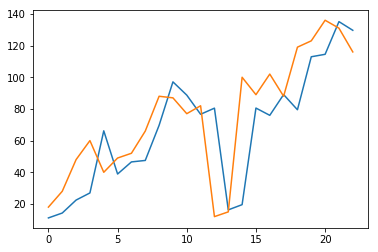

In [49]:
y_truth = y[10:len(y)]
y_truth = y_truth.reshape(len(y_truth),1)
ground_truth = scaler.inverse_transform(y_truth)
y_pred = y_pred.reshape(len(y_pred),1)
predicted = scaler.inverse_transform(y_pred)

plt.plot(predicted)
plt.plot(ground_truth)
plt.show()

In [13]:
years=[]
for t in range(1982,2016):
    years.append(t)

In [423]:
[y_train[19]]

[0.5661764705882353]

In [405]:
y_pred = model.predict(X_test)

In [2]:
one1 = np.array([[ 12.36760169],
       [ 14.36852872],
       [ 22.38855064],
       [ 50.62290215],
       [ 65.28542161],
       [ 39.81606722],
       [ 47.42683387],
       [ 49.61713362],
       [ 66.73844337],
       [ 93.90992403],
       [ 90.6406889 ],
       [ 79.46719694],
       [ 82.61595726],
       [ 19.87209058],
       [ 19.45876396],
       [ 83.10821629],
       [ 75.86160994],
       [ 90.51695538],
       [ 80.09274673],
       [107.31823111],
       [112.432477  ],
       [137.87112904],
       [123.99456549]])

two1 =  np.array([[ 16.06119907],
       [ 14.5542587 ],
       [ 38.55872583],
       [ 65.53764701],
       [ 39.64206696],
       [ 47.28993177],
       [ 50.44996786],
       [ 61.83981919],
       [ 89.31327724],
       [101.29338789],
       [ 91.95199347],
       [ 84.95873117],
       [ 51.96483207],
       [ 17.46764445],
       [ 49.00415254],
       [ 63.46025085],
       [ 90.31232166],
       [ 75.00106859],
       [105.89039946],
       [119.18845367],
       [142.67296886],
       [127.84065628]])

three1 = np.array([[ 23.05974865],
       [ 34.75139904],
       [ 68.83861399],
       [ 51.51619673],
       [ 58.05585051],
       [ 48.2664125 ],
       [ 57.17046762],
       [ 84.54675627],
       [ 91.12331772],
       [ 89.45770597],
       [ 81.74328089],
       [ 54.94743085],
       [ 15.11869055],
       [ 43.57608199],
       [ 65.62854218],
       [ 64.54563069],
       [ 62.65333223],
       [ 96.27297163],
       [ 98.5450511 ],
       [131.1524086 ],
       [124.9811182 ]])

four1 = np.array([[ 37.62062001],
       [ 65.90269899],
       [ 56.76805806],
       [ 60.11069512],
       [ 64.11190677],
       [ 56.13032055],
       [ 74.70266199],
       [ 92.55034685],
       [ 91.29940128],
       [ 97.42147875],
       [ 50.99897456],
       [ 49.88198042],
       [ 69.98402452],
       [ 56.23490715],
       [ 98.65051317],
       [ -2.21970206],
       [ 90.9289465 ],
       [ 99.48666286],
       [133.73978806],
       [136.5049696 ]])

original1 = np.array([[ 18.],
       [ 28.],
       [ 48.],
       [ 60.],
       [ 40.],
       [ 49.],
       [ 52.],
       [ 66.],
       [ 88.],
       [ 87.],
       [ 77.],
       [ 82.],
       [ 12.],
       [ 15.],
       [100.],
       [ 89.],
       [102.],
       [ 88.],
       [119.],
       [123.],
       [136.],
       [131.],
       [116.]])

one2 = np.array([[ 8.58839358],
       [ 4.11925188],
       [12.4457857 ],
       [47.01697409],
       [67.42292178],
       [29.50997645],
       [27.15634304],
       [35.11679977],
       [65.88446581],
       [48.75675368],
       [60.96387029],
       [61.80400622],
       [50.78753114],
       [10.28890161],
       [ 5.0615352 ],
       [52.19559193],
       [56.23839593],
       [59.29112339],
       [46.85608947],
       [60.96908343],
       [59.41721785],
       [79.21117759],
       [71.75611877]])

two2 =  np.array([[ 6.4223897 ],
       [ 7.79197922],
       [30.20736355],
       [69.15638101],
       [ 8.27192655],
       [29.0078361 ],
       [34.50821292],
       [52.06727791],
       [21.2298201 ],
       [54.89896202],
       [56.2488991 ],
       [54.17443788],
       [22.04594457],
       [ 5.11810029],
       [52.20022583],
       [46.76155579],
       [53.36459661],
       [40.74168968],
       [61.19367909],
       [55.1003933 ],
       [84.16592765],
       [69.85501885]])

three2 = np.array([[12.80143523],
       [22.00466746],
       [98.32875657],
       [39.6283918 ],
       [25.66952127],
       [34.38137007],
       [43.07350683],
       [32.24275184],
       [56.47449946],
       [54.86192155],
       [58.57747149],
       [39.83335489],
       [12.34879795],
       [28.79135489],
       [49.78254306],
       [31.96077061],
       [25.92429882],
       [62.82431078],
       [46.28732908],
       [69.55393302],
       [60.08035815]])

four2 = np.array([[21.27555171],
       [68.8378104 ],
       [66.41843092],
       [38.60360456],
       [32.07227647],
       [44.325809  ],
       [44.69847429],
       [58.40605807],
       [62.5494957 ],
       [55.61437726],
       [43.15377486],
       [37.16632044],
       [47.60688949],
       [33.80656612],
       [52.16231906],
       [19.94623908],
       [44.42895436],
       [46.51977777],
       [52.95595706],
       [58.04646409]])

original2 = np.array([[ 3.],
       [23.],
       [37.],
       [49.],
       [29.],
       [28.],
       [35.],
       [66.],
       [52.],
       [62.],
       [61.],
       [53.],
       [ 6.],
       [ 1.],
       [65.],
       [67.],
       [67.],
       [52.],
       [68.],
       [64.],
       [86.],
       [78.],
       [70.]])

one3 = np.array([[10.78139961],
       [ 2.67378201],
       [ 5.42516243],
       [49.68053246],
       [14.35267091],
       [ 8.42042822],
       [15.43682265],
       [12.00544667],
       [ 8.06444255],
       [16.51804602],
       [22.58366156],
       [15.27479327],
       [14.01411211],
       [ 6.15591085],
       [ 6.50484714],
       [22.1572535 ],
       [41.24597406],
       [26.66055095],
       [41.29702306],
       [54.73484898],
       [49.31606007],
       [63.8642776 ],
       [67.81778002]])

two3 =  np.array([[ 8.1445767 ],
       [ 3.74988097],
       [57.61750197],
       [15.09376085],
       [ 6.30922553],
       [12.73581916],
       [10.93507755],
       [ 8.11626315],
       [ 9.36011374],
       [22.47712946],
       [11.61687243],
       [13.99989784],
       [10.46470535],
       [ 7.7272917 ],
       [15.02470791],
       [10.8814224 ],
       [22.7425133 ],
       [40.33491063],
       [70.85524178],
       [63.04739642],
       [67.07361174],
       [80.09722137]])

three3 = np.array([[ 7.08951265],
       [10.72018844],
       [40.20572567],
       [22.87083292],
       [16.20463073],
       [13.04843396],
       [13.02891111],
       [14.05210704],
       [21.37114763],
       [19.75620794],
       [17.78880119],
       [14.22485995],
       [ 8.12283933],
       [11.6436919 ],
       [25.93468654],
       [16.29358244],
       [49.70513892],
       [46.54521227],
       [84.05023336],
       [74.03088236],
       [77.62460995]])

four3 = np.array([[17.64730287],
       [20.52252853],
       [16.41043782],
       [26.05915165],
       [14.17108929],
       [12.2387653 ],
       [16.86796874],
       [21.33697176],
       [17.01864028],
       [17.71731031],
       [13.96896344],
       [19.90005505],
       [19.6468569 ],
       [18.46918356],
       [20.14822733],
       [71.07740116],
       [84.14687586],
       [64.55183601],
       [84.94675016],
       [71.57378626]])

original3 = np.array([[ 1.],
       [ 9.],
       [40.],
       [21.],
       [ 8.],
       [20.],
       [11.],
       [ 6.],
       [32.],
       [32.],
       [16.],
       [14.],
       [ 0.],
       [ 2.],
       [38.],
       [54.],
       [35.],
       [53.],
       [63.],
       [55.],
       [66.],
       [68.],
       [55.]])

In [26]:
# plt.plot(one1[3:],'D--',label='Predicted(lb-1)')
# plt.plot(two1[2:],'D--',label='Predicted(lb-2)')
# plt.plot(three1[1:],'D--',label='Predicted(lb-3)')
# plt.plot(four1,'D--',label='Predicted(lb-4)')
# plt.plot(original1[3:],'bo-',linewidth=2,label='Ground Truth')
# plt.show()
years

NameError: name 'years' is not defined

ValueError: x and y must have same first dimension, but have shapes (2,) and (23, 1)

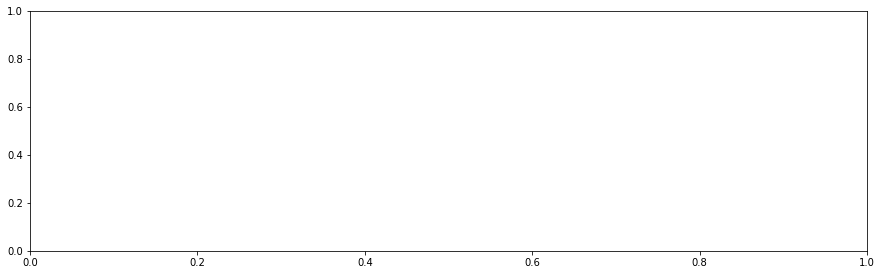

In [4]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(range(21,len(original1)),one1,'-D',label='lookback-1')
plt.plot(range(21,len(original1)),two1,'-D',label='lookback-2')
plt.plot(range(21,len(original1)),three1,'-D',label='lookback-3')
plt.plot(range(21,len(original1)),four1,'-D',label='lookback-4')
plt.plot(original1,'-o',label='original')
plt.xticks(range(0,len(years)),years,rotation=45)
plt.legend(loc='best')
#plt.suptitle('Keyword: Sleep', fontsize=20)
plt.title("Keyword: Sleep", position=(0.3, 0.8),fontsize=15)
plt.xlabel('Time (Year)', fontsize=16)
plt.ylabel('Nodal Degree', fontsize=16)
#--------------------------2
plt.subplot(3,1,2)
plt.plot(range(21,len(original2)),one2,'-D',label='lookback-1')
plt.plot(range(21,len(original2)),two2,'-D',label='lookback-2')
plt.plot(range(21,len(original2)),three2,'-D',label='lookback-3')
plt.plot(range(21,len(original2)),four2,'-D',label='lookback-4')
plt.plot(original2,'-o',label='original')
plt.xticks(range(0,len(years)),years,rotation=45)
plt.legend(loc='best')
#plt.suptitle('Keyword: Sleep', fontsize=20)
plt.title("Keyword: Snoring", position=(0.3, 0.8),fontsize=15)
plt.xlabel('Time (Year)', fontsize=16)
plt.ylabel('Nodal Degree', fontsize=16)
#--------------------------3
plt.subplot(3,1,3)
plt.plot(range(21,len(original3)),one3,'-D',label='lookback-1')
plt.plot(range(21,len(original3)),two3,'-D',label='lookback-2')
plt.plot(range(21,len(original3)),three3,'-D',label='lookback-3')
plt.plot(range(21,len(original3)),four3,'-D',label='lookback-4')
plt.plot(original3,'-o',label='original')
plt.xticks(range(0,len(years)),years,rotation=45)
plt.legend(loc='best')
#plt.suptitle('Keyword: Sleep', fontsize=20)
plt.title("Keyword: Hypertension", position=(0.3, 0.8),fontsize=15)
plt.xlabel('Time (Year)', fontsize=16)
plt.ylabel('Nodal Degree', fontsize=16)
plt.tight_layout()
fig_name = "nodal_degree_timeseries"
fig_file_name = os.path.join(datapath, fig_name + ".png")
plt.savefig(fig_file_name)
plt.show()